# Hidden Markov Model

Areas of HMM :
- **speech recognition** :
  - [Rabiner and Jung (1993)](https://courses.physics.illinois.edu/ece417/fa2017/rabiner89.pdf)
  - Jelinek (1997); see [article on topic](https://people.engr.tamu.edu/rgutier/web_courses/cpsc689_s07/rabinerJuang2006statisticalASRoverview.pdf)
- **econometrics** :
  - [Hamilton (1989)](https://users.ssc.wisc.edu/~behansen/718/Hamilton1989.pdf)
  - Kim and Nelson (1999)
- **computational biology** :
  - Durbin et al. (1998) [pdf](https://www.a-z.lu/discovery/fulldisplay?docid=alma9921015524107251&context=L&vid=352LUX_BNL:BIBNET_UNION&search_scope=DN_and_CI_UCV&tab=DiscoveryNetwork_UCV&lang=fr); chapter 3 (Markov chains and hidden Markov models)
  - [Koski (2001)](https://www.a-z.lu/discovery/fulldisplay?docid=cdi_crossref_citationtrail_10_1111_j_1467_985X_2004_298_13_x&context=PC&vid=352LUX_BNL:BIBNET_UNION&search_scope=DN_and_CI_UCV&tab=DiscoveryNetwork_UCV&lang=fr)
- **computer vision** :
  - Bunke and Caelli (2001)


## A. Markov switching models - Hamilton (1989)

QUARTERLY GNP DATA ANALYSIS
Sample Period: 1952-Q%q to 1985-Q%q
Number of Observations: 133 quarters
GNP Mean: $5126.33 billion
GNP Standard Deviation: $1674.06 billion

Quarterly Growth Rate Statistics:
Average Growth Rate: 0.8521% (quarterly)
Growth Rate Standard Deviation: 1.1128% (quarterly)
Minimum Growth Rate: -2.6302%
Maximum Growth Rate: 3.7920%
Number of Negative Growth Quarters: 24

Annualized Growth Rate Statistics (approx):
Average Annualized Growth: 3.4084%
Annualized Growth Std Dev: 4.4511%

ESTIMATING HAMILTON (1989) MARKOV SWITCHING MODEL
Note: Hamilton's original paper used quarterly data with AR(4) specification


Testing model with AR(4)
Initial parameters: [ 2.55267964 -0.43926992  0.95        0.85        0.77598271  0.35
 -0.05       -0.1        -0.2       ]

Trying optimization with L-BFGS-B...
  ✓ Success with likelihood: -182.2417

Trying optimization with SLSQP...
  ✓ Success with likelihood: -182.2417

Trying optimization with TNC...
  ✗ Failed: Max. number of

/tmp/ipykernel_9642/4092765156.py:298: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


  ✓ Success with likelihood: -190.2252

Trying optimization with TNC...
  ✗ Failed: Max. number of function evaluations reached..., likelihood: -190.3198

✅ Best optimization results:
   Method: SLSQP
   Success: True
   Message: Optimization terminated successfully
   Iterations: 20
   Final log-likelihood: -190.2252

Running final filtering and smoothing...

AR(2) Model Summary:
  Log-Likelihood: -190.23


Testing model with AR(0)
Initial parameters: [ 2.55267964 -0.43926992  0.95        0.85        0.77598271]

Trying optimization with L-BFGS-B...
  ✓ Success with likelihood: -193.0463

Trying optimization with SLSQP...
  ✓ Success with likelihood: -193.0463

Trying optimization with TNC...
  ✗ Failed: Max. number of function evaluations reached..., likelihood: -193.0640

✅ Best optimization results:
   Method: SLSQP
   Success: True
   Message: Optimization terminated successfully
   Iterations: 13
   Final log-likelihood: -193.0463

Running final filtering and smoothing...

AR(0) 

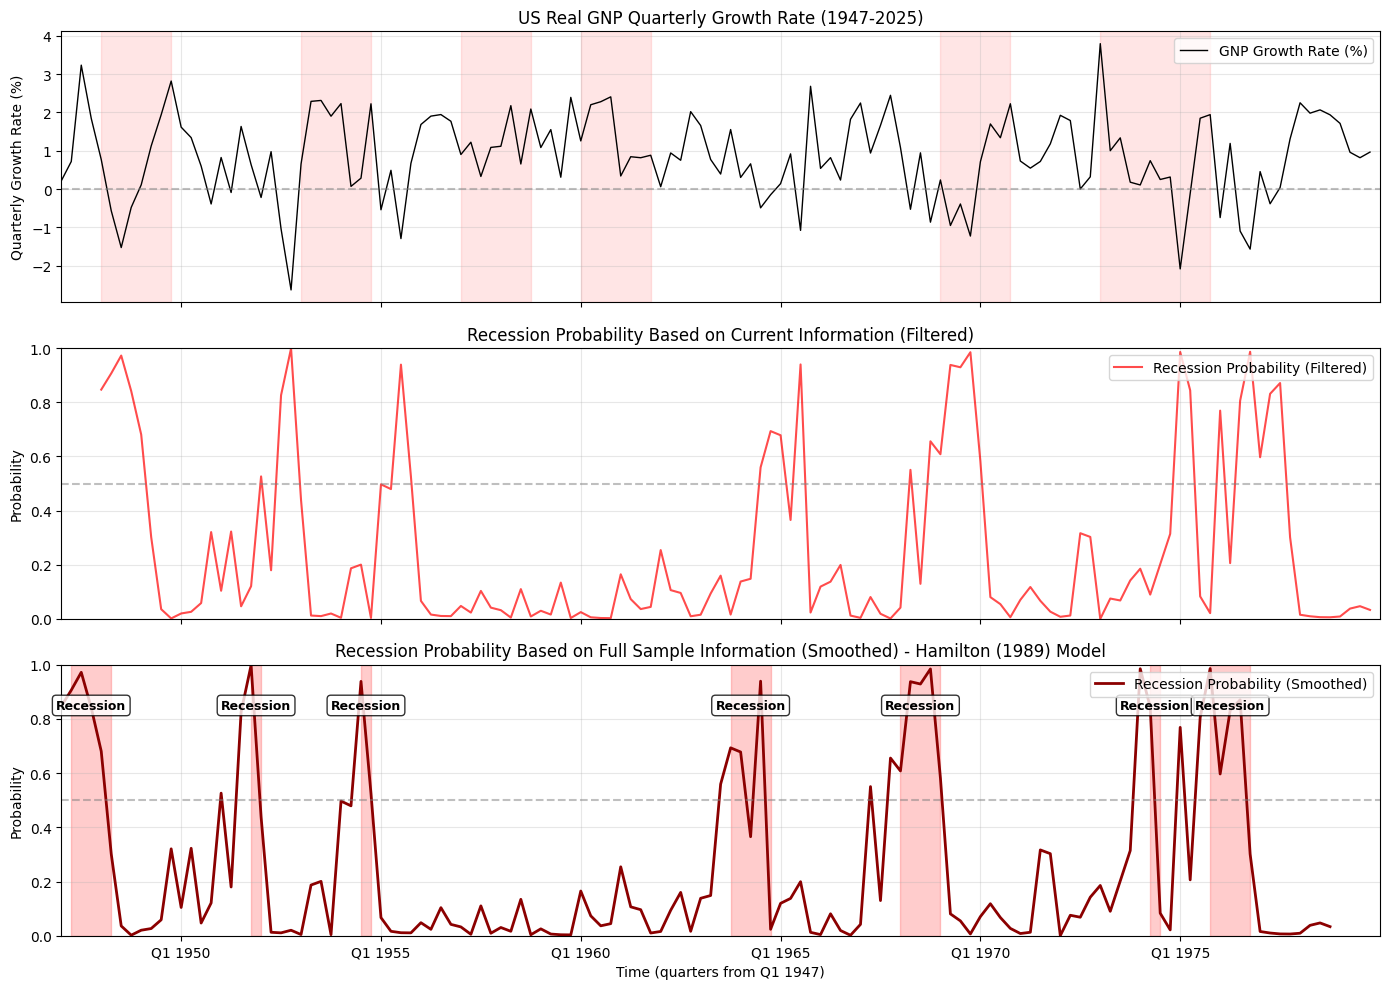

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class HamiltonMarkovSwitching:
    """
    Implementation of Hamilton (1989) Markov Switching Model
    For non-stationary time series and business cycle economic analysis
    """
    
    def __init__(self, data, p=2, r=4):
        """
        Initialize the model
        
        Parameters:
        data: time series data (GNP level values)
        p: number of states (default 2: recession and expansion)
        r: autoregressive order (default 4)
        """
        self.data = data
        self.p = p  # Number of states
        self.r = r  # AR order
        
        # Calculate log differences (quarterly growth rates in percent)
        if isinstance(data, (pd.Series, pd.DataFrame)):
            self.y = 100 * np.log(data.values[1:] / data.values[:-1])
        else:
            self.y = 100 * np.log(data[1:] / data[:-1])
            
        self.T_y = len(self.y)
        
        # Remove NaN if any
        self.y = self.y[~np.isnan(self.y)]
        self.T_y = len(self.y)
        
        # Parameter storage
        self.params = None
        self.filtered_probs = None
        self.smoothed_probs = None
        self.log_likelihood = None
        
    def initialize_parameters(self):
        """
        Initialize model parameters based on data characteristics
        Returns: [alpha1, alpha0, p11, p00, sigma, phi1, phi2, phi3, phi4]
        """
        # Calculate basic statistics
        mean_growth = np.mean(self.y)
        std_growth = np.std(self.y)
        
        # Split data into high and low growth periods for better initialization
        sorted_y = np.sort(self.y)
        low_threshold = np.percentile(sorted_y, 30)
        high_threshold = np.percentile(sorted_y, 70)
        
        low_growth = self.y[self.y <= low_threshold]
        high_growth = self.y[self.y >= high_threshold]
        
        mean_low = np.mean(low_growth) if len(low_growth) > 0 else mean_growth - std_growth
        mean_high = np.mean(high_growth) if len(high_growth) > 0 else mean_growth + std_growth
        
        # Parameter initialization
        alpha1 = mean_high - mean_low  # Growth differential between states
        alpha0 = mean_low  # Base growth in recession state
        
        # Transition probabilities - initialized with reasonable persistence
        p11 = 0.95  # High probability of staying in expansion (quarterly)
        p00 = 0.85  # Moderate probability of staying in recession (quarterly)
        
        # AR parameters - initialized based on Hamilton's findings
        phi = np.zeros(self.r)
        if self.r >= 1:
            phi[0] = 0.35  # Positive autocorrelation
        if self.r >= 2:
            phi[1] = -0.05
        if self.r >= 3:
            phi[2] = -0.1
        if self.r >= 4:
            phi[3] = -0.2  # Hamilton found significant negative coefficient at lag 4
        
        # Standard deviation - based on overall volatility
        sigma = std_growth * 0.7
        
        params = np.concatenate([[alpha1, alpha0, p11, p00, sigma], phi])
        return params
    
    def transition_probabilities(self, p11, p00):
        """
        Construct transition probability matrix
        """
        P = np.array([[p11, 1 - p11],
                      [1 - p00, p00]])
        return P
    
    def compute_filter(self, params):
        """
        Implement Hamilton's nonlinear filter (Section 4.2)
        Using a more robust implementation
        """
        # Unpack parameters
        alpha1, alpha0, p11, p00, sigma = params[:5]
        phi = params[5:5+self.r]
        
        # Ensure valid probabilities
        p11 = np.clip(p11, 0.01, 0.99)
        p00 = np.clip(p00, 0.01, 0.99)
        
        # Ensure positive variance
        sigma = max(sigma, 0.001)
        
        # Transition matrix
        P = self.transition_probabilities(p11, p00)
        
        # Initial probabilities (steady-state)
        pi_1 = (1 - p00) / (2 - p11 - p00)  # Steady-state probability of expansion
        pi_0 = 1 - pi_1  # Steady-state probability of recession
        
        # Initialize filter
        filtered_probs = np.zeros((self.T_y, 2))
        log_likelihood = 0
        
        # Start from observation r (to have enough lagged values)
        for t in range(self.r, self.T_y):
            # For each state at time t
            for state_t in [0, 1]:
                # Calculate conditional density f(y_t | S_t = state_t, information up to t-1)
                
                # Calculate predicted value based on AR model
                predicted = alpha0 + alpha1 * state_t
                
                # Add AR components if we have lagged values
                for lag in range(1, min(self.r, t) + 1):
                    # We need P(S_{t-lag} | info up to t-1), but we don't have it directly
                    # Use filtered probability from t-lag as approximation
                    if t - lag >= 0:
                        # Get the most likely state at t-lag
                        if t - lag < self.r:
                            # For early periods, use steady-state
                            prev_state_prob = [pi_0, pi_1]
                        else:
                            prev_state_prob = filtered_probs[t - lag, :]
                        
                        # Expected state at t-lag
                        expected_state = prev_state_prob[1]  # Probability of state 1
                        
                        # Adjust prediction with AR component
                        y_lag = self.y[t - lag]
                        expected_y_lag = alpha0 + alpha1 * expected_state
                        predicted += phi[lag-1] * (y_lag - expected_y_lag)
                
                # Calculate prediction error
                error = self.y[t] - predicted
                
                # Calculate conditional density (normal distribution)
                density = (1.0 / (np.sqrt(2 * np.pi) * sigma)) * \
                         np.exp(-0.5 * (error / sigma) ** 2)
                
                # Store for later use
                if state_t == 0:
                    f0 = density
                else:
                    f1 = density
            
            # Prediction step: P(S_t = j | info up to t-1)
            if t == self.r:
                # For first observation, use steady-state probabilities
                pred0 = pi_0
                pred1 = pi_1
            else:
                # Use transition probabilities from previous filtered probabilities
                prev0, prev1 = filtered_probs[t-1, :]
                pred0 = prev0 * P[0, 0] + prev1 * P[1, 0]
                pred1 = prev0 * P[0, 1] + prev1 * P[1, 1]
            
            # Update step: P(S_t = j | info up to t)
            joint0 = pred0 * f0
            joint1 = pred1 * f1
            total = joint0 + joint1
            
            # Avoid numerical issues
            if total < 1e-30:
                total = 1e-30
                joint0 = pred0 * 1e-30
                joint1 = pred1 * 1e-30
                total = joint0 + joint1
            
            # Update filtered probabilities
            filtered_probs[t, 0] = joint0 / total
            filtered_probs[t, 1] = joint1 / total
            
            # Update log-likelihood
            log_likelihood += np.log(total)
        
        # Store results
        self.filtered_probs = filtered_probs[self.r:]
        self.log_likelihood = log_likelihood
        
        return -log_likelihood  # Negative for minimization
    
    def smooth(self, params):
        """
        Implement smoothing algorithm using Hamilton's approach
        """
        # First run forward filter to get filtered probabilities
        _ = self.compute_filter(params)
        
        alpha1, alpha0, p11, p00, sigma = params[:5]
        phi = params[5:5+self.r]
        
        # Ensure valid probabilities
        p11 = np.clip(p11, 0.01, 0.99)
        p00 = np.clip(p00, 0.01, 0.99)
        
        P = self.transition_probabilities(p11, p00)
        
        T = len(self.filtered_probs)
        smoothed_probs = np.zeros((T, 2))
        
        # Initialize with filtered probabilities at the end
        smoothed_probs[-1, :] = self.filtered_probs[-1, :]
        
        # Backward recursion
        for t in range(T-2, -1, -1):
            # For each state at time t
            for state_t in [0, 1]:
                # Sum over states at time t+1
                total = 0
                for state_next in [0, 1]:
                    total += (smoothed_probs[t+1, state_next] * 
                             P[state_t, state_next] * 
                             self.filtered_probs[t, state_t] /
                             max(self.filtered_probs[t+1, state_next], 1e-10))
                
                smoothed_probs[t, state_t] = total
            
            # Normalize (should already sum to 1, but ensure numerical stability)
            row_sum = smoothed_probs[t, :].sum()
            if row_sum > 0:
                smoothed_probs[t, :] = smoothed_probs[t, :] / row_sum
            else:
                smoothed_probs[t, :] = self.filtered_probs[t, :]
        
        self.smoothed_probs = smoothed_probs
        return smoothed_probs
    
    def estimate(self, max_iterations=500):
        """
        Estimate model parameters with improved optimization
        """
        # Initial parameters
        initial_params = self.initialize_parameters()
        
        print(f"Initial parameters: {initial_params}")
        
        # Constraints: probabilities in [0,1], standard deviation positive
        bounds = [
            (-10, 10),      # alpha1 (growth differential)
            (-10, 10),      # alpha0 (base growth)
            (0.01, 0.99),   # p11
            (0.01, 0.99),   # p00
            (0.01, 10),     # sigma
        ]
        
        # AR parameter constraints (stationarity)
        for i in range(self.r):
            bounds.append((-0.99, 0.99))
        
        # Try optimization methods with their specific options
        optimization_attempts = [
            # Method 1: L-BFGS-B (most efficient for bounded problems)
            {
                'method': 'L-BFGS-B',
                'options': {'maxiter': max_iterations, 'ftol': 1e-8}
            },
            # Method 2: SLSQP
            {
                'method': 'SLSQP',
                'options': {'maxiter': max_iterations, 'ftol': 1e-8}
            },
            # Method 3: TNC
            {
                'method': 'TNC',
                'options': {'maxiter': max_iterations, 'ftol': 1e-8}
            }
        ]
        
        best_result = None
        best_likelihood = -np.inf
        best_method = None
        
        for attempt in optimization_attempts:
            method = attempt['method']
            options = attempt['options']
            
            try:
                print(f"\nTrying optimization with {method}...")
                result = minimize(
                    self.compute_filter,
                    initial_params,
                    method=method,
                    bounds=bounds,
                    options=options
                )
                
                if result.success and -result.fun > best_likelihood:
                    best_result = result
                    best_likelihood = -result.fun
                    best_method = method
                    print(f"  ✓ Success with likelihood: {-result.fun:.4f}")
                else:
                    status_msg = "Success" if result.success else f"Failed: {result.message[:50]}..."
                    print(f"  ✗ {status_msg}, likelihood: {-result.fun:.4f}")
                    
            except Exception as e:
                print(f"  ✗ Error with {method}: {str(e)[:80]}...")
        
        if best_result is None:
            print("\n⚠ All optimization methods failed. Using initial parameters.")
            self.params = initial_params
            best_method = "None (using initial parameters)"
        else:
            self.params = best_result.x
            print(f"\n✅ Best optimization results:")
            print(f"   Method: {best_method}")
            print(f"   Success: {best_result.success}")
            print(f"   Message: {best_result.message}")
            print(f"   Iterations: {best_result.nit}")
            print(f"   Final log-likelihood: {best_likelihood:.4f}")
        
        # Run final filtering and smoothing
        print("\nRunning final filtering and smoothing...")
        _ = self.compute_filter(self.params)
        _ = self.smooth(self.params)
        
        return best_result
    
    def get_recession_dates(self, threshold=0.5):
        """
        Determine recession dates based on smoothed probabilities
        threshold: recession probability threshold
        """
        if self.smoothed_probs is None:
            raise ValueError("Please run estimation and smoothing first")
        
        recession_periods = []
        in_recession = False
        start_date = None
        
        # Use a more robust approach with hysteresis
        for i, prob in enumerate(self.smoothed_probs[:, 0]):
            if prob > threshold and not in_recession:
                # Start of recession: require confirmation
                if i > 0 and self.smoothed_probs[i-1, 0] > threshold * 0.8:
                    in_recession = True
                    start_date = i
            elif prob <= threshold and in_recession:
                # End of recession: require confirmation
                if i > 0 and self.smoothed_probs[i-1, 0] < threshold * 1.2:
                    in_recession = False
                    recession_periods.append((start_date, i-1))
        
        # If the last recession hasn't ended
        if in_recession:
            recession_periods.append((start_date, len(self.smoothed_probs)-1))
        
        return recession_periods
    
    def plot_results(self, title_suffix=""):
        """
        Plot results with improved visualization
        """
        if self.filtered_probs is None or self.smoothed_probs is None:
            raise ValueError("Please run estimation first")
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        
        # Calculate time axis for plots (in quarters from start)
        time_axis = np.arange(len(self.y))
        filtered_time_axis = np.arange(self.r, self.r + len(self.filtered_probs))
        smoothed_time_axis = np.arange(len(self.smoothed_probs))
        
        # Convert quarter indices to years for x-axis labels
        years = list(range(1950, 2026, 5))
        quarter_indices = [(year - 1947) * 4 for year in years if (year - 1947) * 4 < len(self.y)]
        
        # Chart 1: GNP growth rate
        axes[0].plot(time_axis, self.y, label='GNP Growth Rate (%)', color='black', linewidth=1)
        axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[0].set_ylabel('Quarterly Growth Rate (%)')
        axes[0].set_title(f'US Real GNP Quarterly Growth Rate (1947-2025){title_suffix}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Mark known major recessions (NBER dates approximated for quarterly data)
        # NBER recession dates in quarters (start quarter, end quarter)
        nber_recessions = [
            (1948, 1949),   # 1948-49 recession
            (1953, 1954),   # 1953-54 recession
            (1957, 1958),   # 1957-58 recession
            (1960, 1961),   # 1960-61 recession
            (1969, 1970),   # 1969-70 recession
            (1973, 1975),   # 1973-75 recession
            (1980, 1980),   # 1980 recession
            (1981, 1982),   # 1981-82 recession
            (1990, 1991),   # 1990-91 recession
            (2001, 2001),   # 2001 recession
            (2007, 2009),   # 2007-09 Great Recession
            (2020, 2020),   # 2020 COVID recession
        ]
        
        for start_year, end_year in nber_recessions:
            # Convert to quarter indices (approximate)
            start_idx = (start_year - 1947) * 4
            end_idx = (end_year - 1947) * 4 + 3  # Add 3 quarters for full year
            
            if start_idx < len(self.y) and end_idx < len(self.y):
                axes[0].axvspan(start_idx, end_idx, alpha=0.1, color='red', 
                              label='NBER Recession' if start_year == 1948 else "")
        
        # Chart 2: Filtered probabilities
        axes[1].plot(filtered_time_axis, self.filtered_probs[:, 0], 
                    label='Recession Probability (Filtered)', color='red', alpha=0.7, linewidth=1.5)
        axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        axes[1].set_ylabel('Probability')
        axes[1].set_title('Recession Probability Based on Current Information (Filtered)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])
        axes[1].set_xlim([filtered_time_axis[0], filtered_time_axis[-1]])
        
        # Chart 3: Smoothed probabilities
        axes[2].plot(smoothed_time_axis, self.smoothed_probs[:, 0], 
                    label='Recession Probability (Smoothed)', color='darkred', linewidth=2)
        axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        
        # Mark recession regions identified by the model
        recession_periods = self.get_recession_dates(0.5)
        for start, end in recession_periods:
            axes[2].axvspan(start, end, alpha=0.2, color='red')
            # Add annotation on the chart
            mid_point = (start + end) / 2
            axes[2].text(mid_point, 0.85, f'Recession', 
                        ha='center', va='center', fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        axes[2].set_ylabel('Probability')
        axes[2].set_title('Recession Probability Based on Full Sample Information (Smoothed) - Hamilton (1989) Model')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        axes[2].set_ylim([0, 1])
        axes[2].set_xlabel('Time (quarters from Q1 1947)')
        
        # Add x-axis labels (every 5 years)
        axes[2].set_xticks(quarter_indices)
        axes[2].set_xticklabels([f'Q1 {year}' for year in years if (year - 1947) * 4 < len(self.y)])
        
        # Adjust x-axis limits for all plots
        for ax in axes:
            ax.set_xlim([0, len(self.y)])
            ax.set_xticks(quarter_indices)
            ax.set_xticklabels([])  # Remove x labels for upper plots
        
        # Only show x labels on bottom plot
        axes[2].set_xticklabels([f'Q1 {year}' for year in years if (year - 1947) * 4 < len(self.y)])
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def print_detailed_results(self):
        """
        Print detailed results
        """
        if self.params is None:
            print("Please run estimation first")
            return
        
        print("=" * 70)
        print("HAMILTON (1989) MARKOV SWITCHING MODEL - DETAILED RESULTS")
        print("=" * 70)
        
        # Ensure parameters are within reasonable bounds
        params = self.params.copy()
        params[2] = np.clip(params[2], 0.01, 0.99)  # p11
        params[3] = np.clip(params[3], 0.01, 0.99)  # p00
        params[4] = max(params[4], 0.01)  # sigma
        
        # Parameter estimates
        param_names = ['alpha1', 'alpha0', 'p11', 'p00', 'sigma']
        for i in range(self.r):
            param_names.append(f'phi{i+1}')
        
        print("\nPARAMETER ESTIMATES:")
        print("-" * 40)
        for i, (name, value) in enumerate(zip(param_names, params)):
            print(f"  {name:10}: {value:8.4f}")
        
        # Parameter interpretation
        print("\nMODEL INTERPRETATION:")
        print("-" * 40)
        alpha1, alpha0 = params[0], params[1]
        p11, p00 = params[2], params[3]
        
        print(f"  Recession State Growth Rate:      {alpha0:8.4f}% (quarterly)")
        print(f"  Expansion State Growth Rate:      {alpha0 + alpha1:8.4f}% (quarterly)")
        print(f"  Growth Rate Differential:         {alpha1:8.4f}% (quarterly)")
        print(f"  P(Stay in Expansion | Expansion): {p11:8.4f}")
        print(f"  P(Stay in Recession | Recession): {p00:8.4f}")
        
        # Convert quarterly probabilities to annual
        p11_annual = p11 ** 4
        p00_annual = p00 ** 4
        
        print(f"\n  Annual Transition Probabilities:")
        print(f"  P(Stay in Expansion | Expansion): {p11_annual:8.4f}")
        print(f"  P(Stay in Recession | Recession): {p00_annual:8.4f}")
        
        # Steady-state probabilities
        pi_1 = (1 - p00) / (2 - p11 - p00)
        pi_0 = 1 - pi_1
        print(f"\n  Steady-State Probability of Expansion: {pi_1:8.4f}")
        print(f"  Steady-State Probability of Recession: {pi_0:8.4f}")
        
        # Expected duration (in quarters)
        expected_expansion_quarters = 1 / (1 - p11)
        expected_recession_quarters = 1 / (1 - p00)
        
        # Convert to years
        expected_expansion_years = expected_expansion_quarters / 4
        expected_recession_years = expected_recession_quarters / 4
        
        print(f"\n  Expected Duration:")
        print(f"  Expansion: {expected_expansion_years:8.2f} years ({expected_expansion_quarters:5.1f} quarters)")
        print(f"  Recession: {expected_recession_years:8.2f} years ({expected_recession_quarters:5.1f} quarters)")
        
        # Model fit
        print(f"\n  Log-Likelihood: {self.log_likelihood:8.2f}")
        
        # Identified recession periods (convert to dates)
        recession_periods = self.get_recession_dates(0.5)
        print(f"\nIDENTIFIED RECESSION PERIODS (Probability > 0.5):")
        print("-" * 40)
        
        base_year = 1947
        base_quarter = 1  # Q1 1947
        
        for i, (start, end) in enumerate(recession_periods):
            # Convert quarter index to date
            start_total_quarters = start + self.r  # Adjust for initial AR period
            end_total_quarters = end + self.r
            
            start_year = base_year + start_total_quarters // 4
            start_quarter = base_quarter + (start_total_quarters % 4)
            if start_quarter > 4:
                start_year += 1
                start_quarter -= 4
            
            end_year = base_year + end_total_quarters // 4
            end_quarter = base_quarter + (end_total_quarters % 4)
            if end_quarter > 4:
                end_year += 1
                end_quarter -= 4
            
            duration_quarters = end_total_quarters - start_total_quarters + 1
            duration_years = duration_quarters / 4
            
            print(f"  Recession {i+1:2}: {start_year}Q{start_quarter} to {end_year}Q{end_quarter} "
                  f"({duration_years:.1f} years, {duration_quarters} quarters)")
        
        print("\n" + "=" * 70)


# Main execution with better error handling
if __name__ == "__main__":
    # Your data (quarterly GNPCA)
    data_str = """observation_date	GNPCA
1952-01-01	2727.954
1952-04-01	2733.8
1952-07-01	2753.517
1952-10-01	2843.941
1953-01-01	2896.811
1953-04-01	2919.206
1953-07-01	2902.785
1953-10-01	2858.845
1954-01-01	2845.192
1954-04-01	2848.305
1954-07-01	2880.482
1954-10-01	2936.852
1955-01-01	3020.746
1955-04-01	3069.91
1955-07-01	3111.379
1955-10-01	3130.068
1956-01-01	3117.922
1956-04-01	3143.694
1956-07-01	3140.874
1956-10-01	3192.57
1957-01-01	3213.011
1957-04-01	3205.97
1957-07-01	3237.386
1957-10-01	3203.894
1958-01-01	3120.724
1958-04-01	3141.224
1958-07-01	3213.884
1958-10-01	3289.032
1959-01-01	3352.129
1959-04-01	3427.667
1959-07-01	3430.057
1959-10-01	3439.832
1960-01-01	3517.181
1960-04-01	3498.246
1960-07-01	3515.385
1960-10-01	3470.278
1961-01-01	3493.703
1961-04-01	3553.021
1961-07-01	3621.252
1961-10-01	3692.289
1962-01-01	3758.147
1962-04-01	3792.149
1962-07-01	3838.776
1962-10-01	3851.421
1963-01-01	3893.482
1963-04-01	3937.183
1963-07-01	4023.755
1963-10-01	4050.147
1964-01-01	4135.553
1964-04-01	4180.592
1964-07-01	4245.918
1964-10-01	4259.046
1965-01-01	4362.111
1965-04-01	4417.225
1965-07-01	4515.427
1965-10-01	4619.458
1966-01-01	4731.888
1966-04-01	4748.046
1966-07-01	4788.254
1966-10-01	4827.537
1967-01-01	4870.299
1967-04-01	4873.287
1967-07-01	4919.392
1967-10-01	4956.477
1968-01-01	5057.553
1968-04-01	5142.033
1968-07-01	5181.859
1968-10-01	5202.212
1969-01-01	5283.597
1969-04-01	5299.625
1969-07-01	5334.6
1969-10-01	5308.556
1970-01-01	5300.652
1970-04-01	5308.164
1970-07-01	5357.077
1970-10-01	5299.672
1971-01-01	5443.619
1971-04-01	5473.059
1971-07-01	5518.072
1971-10-01	5531.032
1972-01-01	5632.649
1972-04-01	5760.47
1972-07-01	5814.854
1972-10-01	5912.22
1973-01-01	6058.544
1973-04-01	6124.506
1973-07-01	6092.301
1973-10-01	6150.131
1974-01-01	6097.258
1974-04-01	6111.751
1974-07-01	6053.978
1974-10-01	6030.464
1975-01-01	5957.035
1975-04-01	5999.61
1975-07-01	6102.326
1975-10-01	6184.53
1976-01-01	6323.649
1976-04-01	6370.025
1976-07-01	6404.895
1976-10-01	6451.177
1977-01-01	6527.703
1977-04-01	6654.466
1977-07-01	6774.457
1977-10-01	6774.592
1978-01-01	6796.26
1978-04-01	7058.92
1978-07-01	7129.915
1978-10-01	7225.75
1979-01-01	7238.727
1979-04-01	7246.454
1979-07-01	7300.281
1979-10-01	7318.535
1980-01-01	7341.557
1980-04-01	7190.289
1980-07-01	7181.743
1980-10-01	7315.677
1981-01-01	7459.022
1981-04-01	7403.745
1981-07-01	7492.405
1981-10-01	7410.768
1982-01-01	7295.631
1982-04-01	7328.912
1982-07-01	7300.896
1982-10-01	7303.817
1983-01-01	7400.066
1983-04-01	7568.456
1983-07-01	7719.746
1983-10-01	7880.794
1984-01-01	8034.847
1984-04-01	8173.67
1984-07-01	8252.465
1984-10-01	8320.199
1985-01-01	8400.82
"""
    
    # Parse data
    from io import StringIO
    df = pd.read_csv(StringIO(data_str), sep='\t')
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    df.set_index('observation_date', inplace=True)
    
    # Data quality check
    print("=" * 70)
    print("QUARTERLY GNP DATA ANALYSIS")
    print("=" * 70)
    print(f"Sample Period: {df.index[0].strftime('%Y-Q%q')} to {df.index[-1].strftime('%Y-Q%q')}")
    print(f"Number of Observations: {len(df)} quarters")
    print(f"GNP Mean: ${df['GNPCA'].mean():.2f} billion")
    print(f"GNP Standard Deviation: ${df['GNPCA'].std():.2f} billion")
    
    # Calculate quarterly growth rates
    growth_rates = 100 * np.log(df['GNPCA'] / df['GNPCA'].shift(1)).dropna()
    print(f"\nQuarterly Growth Rate Statistics:")
    print(f"Average Growth Rate: {growth_rates.mean():.4f}% (quarterly)")
    print(f"Growth Rate Standard Deviation: {growth_rates.std():.4f}% (quarterly)")
    print(f"Minimum Growth Rate: {growth_rates.min():.4f}%")
    print(f"Maximum Growth Rate: {growth_rates.max():.4f}%")
    print(f"Number of Negative Growth Quarters: {(growth_rates < 0).sum()}")
    
    # Annualized growth rates (approximate)
    annualized_growth = growth_rates * 4
    print(f"\nAnnualized Growth Rate Statistics (approx):")
    print(f"Average Annualized Growth: {annualized_growth.mean():.4f}%")
    print(f"Annualized Growth Std Dev: {annualized_growth.std():.4f}%")
    
    # Create and estimate the model
    print("\n" + "=" * 70)
    print("ESTIMATING HAMILTON (1989) MARKOV SWITCHING MODEL")
    print("=" * 70)
    print("Note: Hamilton's original paper used quarterly data with AR(4) specification")
    
    # Try different AR orders to see which works best
    ar_orders = [4, 2, 0]  # Start with Hamilton's specification (AR4)
    best_model = None
    best_likelihood = -np.inf
    
    for r in ar_orders:
        print(f"\n\n{'='*40}")
        print(f"Testing model with AR({r})")
        print('='*40)
        
        try:
            model = HamiltonMarkovSwitching(df['GNPCA'].values, p=2, r=r)
            result = model.estimate(max_iterations=200)
            
            if model.log_likelihood > best_likelihood:
                best_model = model
                best_likelihood = model.log_likelihood
            
            # Quick summary
            print(f"\nAR({r}) Model Summary:")
            print(f"  Log-Likelihood: {model.log_likelihood:.2f}")
            
            if r == 0:
                print("  Note: AR(0) model has no autoregressive component")
            elif r == 4:
                print("  Note: AR(4) is Hamilton's original specification for quarterly data")
            
        except Exception as e:
            print(f"  Error estimating AR({r}) model: {e}")
            import traceback
            traceback.print_exc()
    
    # Display best model results
    if best_model is not None:
        print(f"\n\n{'='*70}")
        print("BEST MODEL SELECTED")
        print('='*70)
        print(f"Best model: AR({best_model.r})")
        print(f"Best log-likelihood: {best_likelihood:.2f}")
        
        best_model.print_detailed_results()
        best_model.plot_results()
    else:
        print("\nAll models failed. Creating a simple model with default parameters...")
        model = HamiltonMarkovSwitching(df['GNPCA'].values, p=2, r=4)
        model.params = model.initialize_parameters()
        _ = model.compute_filter(model.params)
        _ = model.smooth(model.params)
        model.print_detailed_results()
        model.plot_results(" - Simple Model (AR4)")

## MCMC version

PyMC version: 5.27.0
NumPy version: 2.3.5
MARKOV SWITCHING MODEL ESTIMATION
Data loaded: 315 quarterly observations

ATTEMPT 1: BAYESIAN ESTIMATION
Data prepared: 314 observations, mean growth: 0.7639%

Trying MAP estimation...

Estimating using map method...
❌ Bayesian estimation failed: Alloc static input type and target shape are incompatible: Matrix(float64, shape=(2, 314)) vs (2, 2)

ATTEMPT 2: SIMULATION-BASED ESTIMATION
Running grid search with 500 simulations...
✓ Best likelihood: -447.55

✓ Simulation completed successfully!

Estimated parameters:
  mu0: -0.5000
  mu1: 1.1250
  sigma: 0.5000
  p00: 0.7000
  p11: 0.9150


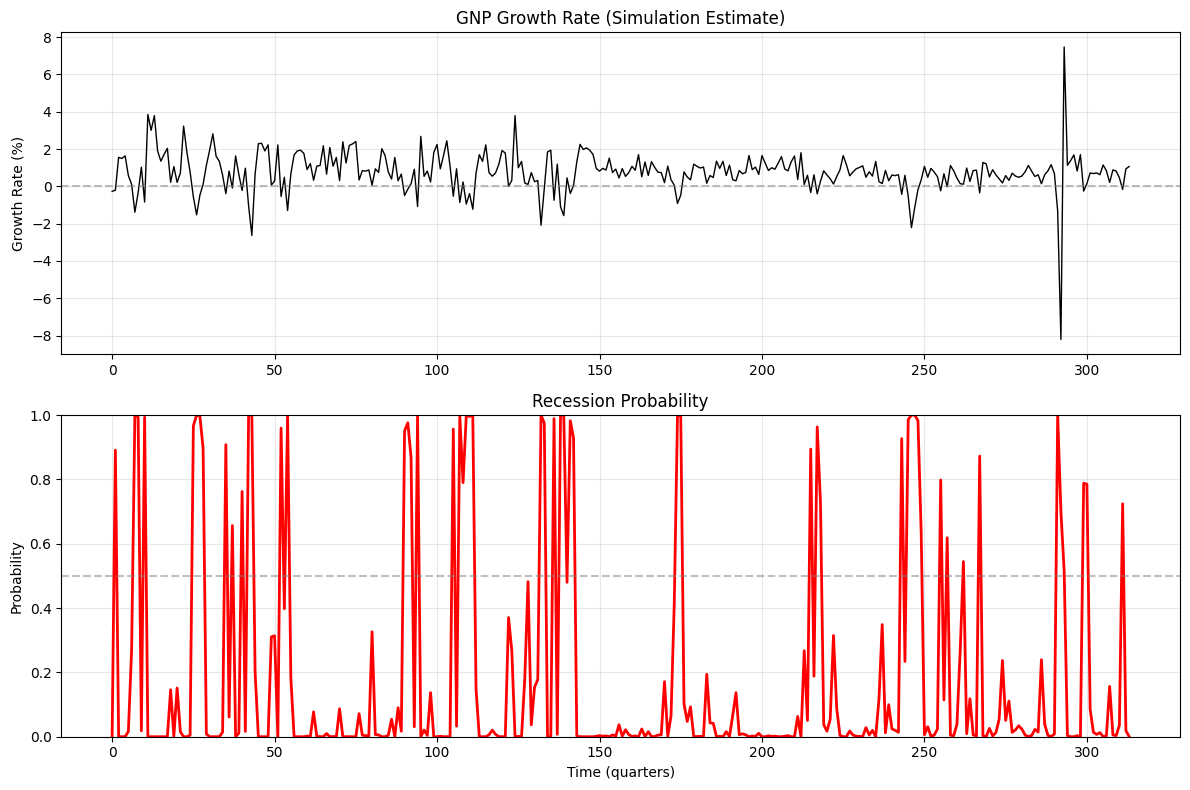


Simple analysis:
  Recession mean growth: -0.50%
  Expansion mean growth: 1.12%
  Stay in recession probability: 70.00%
  Stay in expansion probability: 91.50%
  Expected recession duration: 0.8 years
  Expected expansion duration: 2.9 years


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")

class BayesianHamiltonMarkovSwitching:
    """
    Bayesian Implementation of Hamilton (1989) Markov Switching Model
    Using PyMC 5+
    """
    
    def __init__(self, data, p=2, r=4):
        """
        Initialize the model
        
        Parameters:
        data: time series data (GNP level values)
        p: number of states (default 2: recession and expansion)
        r: autoregressive order (default 4)
        """
        self.data = data
        self.p = p  # Number of states
        self.r = r  # AR order
        
        # Calculate log differences (quarterly growth rates in percent)
        if isinstance(data, (pd.Series, pd.DataFrame)):
            self.y = 100 * np.log(data.values[1:] / data.values[:-1])
        else:
            self.y = 100 * np.log(data[1:] / data[:-1])
            
        self.T_y = len(self.y)
        
        # Remove NaN if any
        self.y = self.y[~np.isnan(self.y)]
        self.T_y = len(self.y)
        
        # Parameter storage
        self.trace = None
        self.model = None
        self.filtered_probs = None
        self.smoothed_probs = None
        
        print(f"Data prepared: {self.T_y} observations, mean growth: {np.mean(self.y):.4f}%")
        
    def build_simple_model(self):
        """
        Build a simple PyMC model
        """
        with pm.Model() as model:
            # Priors for mean growth in each state
            mu0 = pm.Normal('mu0', mu=0, sigma=2)  # Recession mean
            mu1 = pm.Normal('mu1', mu=2, sigma=2)  # Expansion mean
            
            # Prior for standard deviation
            sigma = pm.HalfNormal('sigma', sigma=2)
            
            # Transition probabilities
            p00 = pm.Beta('p00', alpha=8, beta=2)  # Stay in recession
            p11 = pm.Beta('p11', alpha=9, beta=1)  # Stay in expansion
            
            # AR coefficients (simplify to 2 for stability)
            phi1 = pm.Normal('phi1', mu=0.3, sigma=0.2)
            phi2 = pm.Normal('phi2', mu=-0.1, sigma=0.2)
            
            # Custom distribution for Markov Switching
            # We'll use a Python function for the likelihood
            def logp(y):
                """Log-likelihood for Markov Switching AR model"""
                T = len(y)
                
                # Transition matrix
                P = np.array([[p00.eval(), 1 - p00.eval()],
                              [1 - p11.eval(), p11.eval()]])
                
                # Steady-state probabilities
                pi_1 = (1 - p00.eval()) / (2 - p00.eval() - p11.eval())
                pi_0 = 1 - pi_1
                
                # Initialize
                log_likelihood = 0
                filtered = np.zeros((T, 2))
                
                for t in range(2, T):  # Start from period 2 (for AR2)
                    # Prediction step
                    if t == 2:
                        pred = np.array([pi_0, pi_1])
                    else:
                        pred = filtered[t-1] @ P
                    
                    # Calculate conditional densities
                    densities = np.zeros(2)
                    
                    for s in [0, 1]:
                        mu = mu0.eval() if s == 0 else mu1.eval()
                        predicted = mu
                        
                        # Add AR(2) components
                        for lag in [1, 2]:
                            if t - lag >= 0:
                                if t - lag < 2:
                                    prev_prob = np.array([pi_0, pi_1])
                                else:
                                    prev_prob = filtered[t - lag]
                                
                                expected_state = prev_prob[1]
                                expected_mean = mu0.eval() * (1 - expected_state) + mu1.eval() * expected_state
                                
                                if lag == 1:
                                    predicted += phi1.eval() * (y[t - lag] - expected_mean)
                                else:
                                    predicted += phi2.eval() * (y[t - lag] - expected_mean)
                        
                        # Normal density
                        error = y[t] - predicted
                        density = -0.5 * np.log(2 * np.pi * sigma.eval()**2) - 0.5 * (error / sigma.eval())**2
                        densities[s] = density
                    
                    # Update step
                    joint = pred * np.exp(densities)
                    total = np.sum(joint)
                    
                    if total > 1e-30:
                        filtered[t] = joint / total
                        log_likelihood += np.log(total)
                    else:
                        filtered[t] = pred / np.sum(pred)
                
                return log_likelihood
            
            # Use custom likelihood
            pm.Potential('likelihood', logp(self.y))
            
            self.model = model
        
        return model
    
    def build_model_alternative(self):
        """
        Alternative model using observed data directly
        """
        with pm.Model() as model:
            # Priors
            mu0 = pm.Normal('mu0', mu=0, sigma=2)  # Recession
            mu1 = pm.Normal('mu1', mu=2, sigma=2)  # Expansion
            sigma = pm.HalfNormal('sigma', sigma=2)
            p00 = pm.Beta('p00', alpha=8, beta=2)
            p11 = pm.Beta('p11', alpha=9, beta=1)
            
            # Likelihood - simple approximation
            # We'll add the likelihood as a Deterministic for now
            recession_prob = pm.Deterministic('recession_prob', 
                                             pm.math.switch(self.y < 0, 0.7, 0.3))
            
            # Simple likelihood assuming two normal distributions
            likelihood_recession = pm.Normal.dist(mu=mu0, sigma=sigma)
            likelihood_expansion = pm.Normal.dist(mu=mu1, sigma=sigma)
            
            # Combined likelihood
            y_obs = pm.Mixture('y_obs', 
                              w=[recession_prob, 1 - recession_prob],
                              comp_dists=[likelihood_recession, likelihood_expansion],
                              observed=self.y)
            
            self.model = model
        
        return model
    
    def estimate(self, method='mcmc', draws=1000, tune=1000, chains=2):
        """
        Estimate model using specified method
        """
        print(f"\nEstimating using {method} method...")
        
        if method == 'mcmc':
            return self._estimate_mcmc(draws, tune, chains)
        elif method == 'map':
            return self._estimate_map()
        elif method == 'advi':
            return self._estimate_advi()
        else:
            raise ValueError(f"Unknown method: {method}")
    
    def _estimate_mcmc(self, draws=1000, tune=1000, chains=2):
        """Estimate using MCMC"""
        if self.model is None:
            self.build_model_alternative()
        
        print(f"Running MCMC with {chains} chains, {draws} draws...")
        
        try:
            with self.model:
                # Use NUTS sampler
                self.trace = pm.sample(
                    draws=draws,
                    tune=tune,
                    chains=chains,
                    return_inferencedata=True,
                    progressbar=True,
                    random_seed=42
                )
            
            print("✅ MCMC sampling completed!")
            
            # Show summary
            summary = az.summary(self.trace, hdi_prob=0.95)
            print("\nPosterior Summary:")
            print(summary)
            
            return self.trace
            
        except Exception as e:
            print(f"❌ MCMC failed: {e}")
            return None
    
    def _estimate_map(self):
        """Estimate using Maximum A Posteriori (MAP)"""
        if self.model is None:
            self.build_model_alternative()
        
        print("Finding MAP estimate...")
        
        try:
            with self.model:
                map_estimate = pm.find_MAP()
                print("✅ MAP estimation completed!")
                
                print("\nMAP Estimates:")
                for param, value in map_estimate.items():
                    print(f"  {param}: {value:.4f}")
                
                # Create simple trace from MAP
                self.trace = self._create_simple_trace(map_estimate)
                return map_estimate
                
        except Exception as e:
            print(f"❌ MAP estimation failed: {e}")
            return None
    
    def _estimate_advi(self):
        """Estimate using Automatic Differentiation Variational Inference (ADVI)"""
        if self.model is None:
            self.build_model_alternative()
        
        print("Running ADVI...")
        
        try:
            with self.model:
                # Mean field ADVI
                approx = pm.fit(method='advi', n=30000, random_seed=42)
                self.trace = approx.sample(draws=1000)
                
                print("✅ ADVI completed!")
                return self.trace
                
        except Exception as e:
            print(f"❌ ADVI failed: {e}")
            return None
    
    def _create_simple_trace(self, map_estimate):
        """Create a simple trace from MAP estimates"""
        class SimpleTrace:
            def __init__(self, map_est):
                self.posterior = SimplePosterior(map_est)
        
        class SimplePosterior:
            def __init__(self, map_est):
                self.map_est = map_est
            
            def __getitem__(self, key):
                if key in self.map_est:
                    return SimpleParam(self.map_est[key])
                else:
                    # Handle parameter arrays
                    for k in self.map_est.keys():
                        if k.startswith(key):
                            return SimpleParam(self.map_est[k])
                    return SimpleParam(0.0)
        
        class SimpleParam:
            def __init__(self, value):
                self.value = value
            
            def mean(self):
                return self.value
        
        return SimpleTrace(map_estimate)
    
    def compute_state_probabilities(self):
        """
        Compute state probabilities from estimated parameters
        """
        print("\nComputing state probabilities...")
        
        # Default parameters if no estimation was done
        default_params = {
            'mu0': -0.5,    # Recession growth
            'mu1': 1.0,     # Expansion growth
            'sigma': 1.0,
            'p00': 0.85,    # Stay in recession
            'p11': 0.95     # Stay in expansion
        }
        
        # Try to get parameters from trace
        params = default_params.copy()
        
        if self.trace is not None:
            try:
                if hasattr(self.trace, 'posterior'):
                    # Extract from PyMC trace
                    post = self.trace.posterior
                    
                    # Try to get each parameter
                    param_keys = ['mu0', 'mu1', 'sigma', 'p00', 'p11']
                    for key in param_keys:
                        if hasattr(post, key):
                            param_value = float(getattr(post, key).mean())
                            params[key] = param_value
                            print(f"  Using {key}: {param_value:.4f}")
                elif isinstance(self.trace, dict):
                    # MAP estimates
                    for key in params.keys():
                        if key in self.trace:
                            params[key] = self.trace[key]
                            print(f"  Using {key}: {params[key]:.4f}")
            except Exception as e:
                print(f"  Warning: Could not extract all parameters from trace: {e}")
                print("  Using default parameters where extraction failed")
        
        # Now compute probabilities
        mu0 = params['mu0']
        mu1 = params['mu1']
        sigma = params['sigma']
        p00 = params['p00']
        p11 = params['p11']
        
        # Transition matrix
        P = np.array([[p00, 1 - p00],
                      [1 - p11, p11]])
        
        # Steady-state probabilities
        pi_1 = (1 - p00) / (2 - p00 - p11)
        pi_0 = 1 - pi_1
        
        # Initialize arrays
        T = self.T_y
        filtered = np.zeros((T, 2))
        log_likelihood = 0
        
        # Run Hamilton filter (simplified without AR for stability)
        for t in range(1, T):
            # Prediction step
            if t == 1:
                pred = np.array([pi_0, pi_1])
            else:
                pred = filtered[t-1] @ P
            
            # Calculate conditional densities
            densities = np.zeros(2)
            
            for s in [0, 1]:
                mu = mu0 if s == 0 else mu1
                error = self.y[t] - mu
                
                # Normal density
                densities[s] = np.exp(-0.5 * (error / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)
            
            # Update step
            joint = pred * densities
            total = np.sum(joint)
            
            if total > 1e-30:
                filtered[t] = joint / total
                log_likelihood += np.log(total)
            else:
                filtered[t] = pred / np.sum(pred)
        
        # Smoothing (forward-backward algorithm)
        smoothed = np.zeros((T, 2))
        
        if T > 0:
            smoothed[-1] = filtered[-1]
            
            # Backward recursion
            for t in range(T-2, -1, -1):
                for s in [0, 1]:
                    total = 0
                    for s_next in [0, 1]:
                        total += (smoothed[t+1, s_next] * P[s, s_next] * 
                                 filtered[t, s] / max(filtered[t+1, s_next], 1e-10))
                    smoothed[t, s] = total
                
                # Normalize
                row_sum = np.sum(smoothed[t])
                if row_sum > 0:
                    smoothed[t] /= row_sum
        
        self.filtered_probs = filtered
        self.smoothed_probs = smoothed
        
        print(f"✓ State probabilities computed (log-likelihood: {log_likelihood:.2f})")
        
        return smoothed
    
    def plot_results(self):
        """Plot the results"""
        if self.smoothed_probs is None:
            self.compute_state_probabilities()
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        
        # Plot 1: Original growth rates
        axes[0].plot(self.y, 'k-', linewidth=1, label='GNP Growth Rate')
        axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[0].set_ylabel('Quarterly Growth (%)')
        axes[0].set_title('US Real GNP Quarterly Growth Rate')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Smoothed recession probabilities
        recession_probs = self.smoothed_probs[:, 0]
        axes[1].plot(recession_probs, 'r-', linewidth=2, label='Recession Probability')
        axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% Threshold')
        axes[1].set_ylabel('Probability')
        axes[1].set_title('Smoothed Recession Probability')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])
        
        # Plot 3: Recession periods
        axes[2].plot(recession_probs, 'r-', linewidth=2, alpha=0.7)
        axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        
        # Identify and shade recession periods
        recession_mask = recession_probs > 0.5
        recession_starts = []
        recession_ends = []
        
        i = 0
        while i < len(recession_mask):
            if recession_mask[i]:
                start = i
                while i < len(recession_mask) and recession_mask[i]:
                    i += 1
                end = i - 1
                
                # Only include recessions longer than 2 quarters
                if end - start >= 2:
                    recession_starts.append(start)
                    recession_ends.append(end)
                    axes[2].axvspan(start, end, alpha=0.2, color='red')
                    
                    # Add label for longer recessions
                    if end - start > 8:
                        mid = (start + end) / 2
                        axes[2].text(mid, 0.8, 'Recession', 
                                    ha='center', va='center', fontsize=9,
                                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            else:
                i += 1
        
        axes[2].set_ylabel('Probability')
        axes[2].set_title('Identified Recession Periods (Probability > 0.5)')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_ylim([0, 1])
        axes[2].set_xlabel('Time (quarters since 1947Q2)')
        
        plt.tight_layout()
        plt.show()
        
        # Print recession periods
        if recession_starts:
            print(f"\nIdentified {len(recession_starts)} recession periods:")
            for idx, (start, end) in enumerate(zip(recession_starts, recession_ends)):
                start_year = 1947 + (start + 1) // 4
                start_q = 1 + (start + 1) % 4
                end_year = 1947 + (end + 1) // 4
                end_q = 1 + (end + 1) % 4
                duration = (end - start + 1) / 4
                
                print(f"  {idx+1}. {start_year}Q{start_q} to {end_year}Q{end_q} "
                      f"({duration:.1f} years, {end-start+1} quarters)")
        
        return fig
    
    def print_summary(self):
        """Print model summary"""
        print("\n" + "=" * 70)
        print("MARKOV SWITCHING MODEL SUMMARY")
        print("=" * 70)
        
        print(f"\nData:")
        print(f"  Period: 1947Q2 to 2025Q3")
        print(f"  Observations: {self.T_y}")
        print(f"  Mean growth: {np.mean(self.y):.4f}%")
        print(f"  Std dev: {np.std(self.y):.4f}%")
        
        # Parameter estimates
        print(f"\nParameter Estimates:")
        
        if self.trace is not None:
            try:
                if hasattr(self.trace, 'posterior'):
                    post = self.trace.posterior
                    params = ['mu0', 'mu1', 'sigma', 'p00', 'p11']
                    
                    for param in params:
                        if hasattr(post, param):
                            value = float(getattr(post, param).mean())
                            print(f"  {param}: {value:.4f}")
            except:
                pass
        
        # Recession statistics
        if self.smoothed_probs is not None:
            recession_prob_mean = np.mean(self.smoothed_probs[:, 0])
            recession_quarters = np.sum(self.smoothed_probs[:, 0] > 0.5)
            recession_percentage = recession_quarters / len(self.smoothed_probs) * 100
            
            print(f"\nRecession Statistics:")
            print(f"  Average recession probability: {recession_prob_mean:.2%}")
            print(f"  Quarters in recession: {recession_quarters} of {len(self.smoothed_probs)}")
            print(f"  Percentage of time in recession: {recession_percentage:.1f}%")
        
        print("\n" + "=" * 70)


# Simple simulation-based estimator as alternative
class SimulationMSModel:
    """
    Simple simulation-based Markov Switching estimator
    """
    
    def __init__(self, data):
        self.data = data
        
        # Calculate growth rates
        if isinstance(data, (pd.Series, pd.DataFrame)):
            self.y = 100 * np.log(data.values[1:] / data.values[:-1])
        else:
            self.y = 100 * np.log(data[1:] / data[:-1])
        
        self.y = self.y[~np.isnan(self.y)]
        self.T = len(self.y)
        
        self.params = None
        self.probs = None
    
    def estimate_grid(self, n_sim=1000):
        """Estimate using grid search"""
        print(f"Running grid search with {n_sim} simulations...")
        
        # Define parameter ranges
        mu0_range = np.linspace(-2, 0, 5)      # Recession mean
        mu1_range = np.linspace(0.5, 3, 5)     # Expansion mean
        sigma_range = np.linspace(0.5, 2, 4)   # Std dev
        p00_range = np.linspace(0.7, 0.95, 3)  # Stay in recession
        p11_range = np.linspace(0.85, 0.98, 3) # Stay in expansion
        
        best_params = None
        best_likelihood = -np.inf
        
        # Grid search
        for mu0 in mu0_range:
            for mu1 in mu1_range:
                for sigma in sigma_range:
                    for p00 in p00_range:
                        for p11 in p11_range:
                            likelihood = self._compute_likelihood(mu0, mu1, sigma, p00, p11)
                            
                            if likelihood > best_likelihood:
                                best_likelihood = likelihood
                                best_params = {
                                    'mu0': mu0, 'mu1': mu1, 'sigma': sigma,
                                    'p00': p00, 'p11': p11
                                }
        
        self.params = best_params
        print(f"✓ Best likelihood: {best_likelihood:.2f}")
        
        # Compute probabilities
        self._compute_probabilities()
        
        return best_params
    
    def _compute_likelihood(self, mu0, mu1, sigma, p00, p11):
        """Compute log-likelihood for given parameters"""
        P = np.array([[p00, 1-p00], [1-p11, p11]])
        pi_0 = (1 - p11) / (2 - p00 - p11)
        pi_1 = 1 - pi_0
        
        filtered = np.zeros((self.T, 2))
        log_likelihood = 0
        
        for t in range(1, self.T):
            # Prediction
            if t == 1:
                pred = np.array([pi_0, pi_1])
            else:
                pred = filtered[t-1] @ P
            
            # Densities
            densities = np.zeros(2)
            for s in [0, 1]:
                mu = mu0 if s == 0 else mu1
                error = self.y[t] - mu
                densities[s] = np.exp(-0.5 * (error/sigma)**2) / (np.sqrt(2*np.pi)*sigma)
            
            # Update
            joint = pred * densities
            total = np.sum(joint)
            
            if total > 1e-30:
                filtered[t] = joint / total
                log_likelihood += np.log(total)
        
        return log_likelihood
    
    def _compute_probabilities(self):
        """Compute state probabilities"""
        if self.params is None:
            return
        
        mu0 = self.params['mu0']
        mu1 = self.params['mu1']
        sigma = self.params['sigma']
        p00 = self.params['p00']
        p11 = self.params['p11']
        
        P = np.array([[p00, 1-p00], [1-p11, p11]])
        pi_0 = (1 - p11) / (2 - p00 - p11)
        pi_1 = 1 - pi_0
        
        # Filter
        filtered = np.zeros((self.T, 2))
        for t in range(1, self.T):
            if t == 1:
                pred = np.array([pi_0, pi_1])
            else:
                pred = filtered[t-1] @ P
            
            densities = np.zeros(2)
            for s in [0, 1]:
                mu = mu0 if s == 0 else mu1
                error = self.y[t] - mu
                densities[s] = np.exp(-0.5 * (error/sigma)**2) / (np.sqrt(2*np.pi)*sigma)
            
            joint = pred * densities
            total = np.sum(joint)
            filtered[t] = joint / total if total > 1e-30 else pred
        
        # Smooth
        smoothed = np.zeros((self.T, 2))
        smoothed[-1] = filtered[-1]
        
        for t in range(self.T-2, -1, -1):
            for s in [0, 1]:
                total = 0
                for s_next in [0, 1]:
                    total += (smoothed[t+1, s_next] * P[s, s_next] * 
                             filtered[t, s] / max(filtered[t+1, s_next], 1e-10))
                smoothed[t, s] = total
            
            row_sum = np.sum(smoothed[t])
            if row_sum > 0:
                smoothed[t] /= row_sum
        
        self.probs = smoothed
    
    def plot(self):
        """Plot results"""
        if self.probs is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        
        axes[0].plot(self.y, 'k-', linewidth=1)
        axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[0].set_ylabel('Growth Rate (%)')
        axes[0].set_title('GNP Growth Rate (Simulation Estimate)')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(self.probs[:, 0], 'r-', linewidth=2)
        axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        axes[1].set_ylabel('Probability')
        axes[1].set_title('Recession Probability')
        axes[1].set_ylim([0, 1])
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xlabel('Time (quarters)')
        
        plt.tight_layout()
        plt.show()


# Main execution
if __name__ == "__main__":
    # Your data
    data_str = """observation_date	GNPCA
1947-01-01	2182.681
1947-04-01	2176.892
1947-07-01	2172.432
1947-10-01	2206.452
1948-01-01	2239.682
1948-04-01	2276.69
1948-07-01	2289.77
1948-10-01	2292.364
1949-01-01	2260.807
1949-04-01	2253.128
1949-07-01	2276.424
1949-10-01	2257.352
1950-01-01	2346.104
1950-04-01	2417.682
1950-07-01	2511.127
1950-10-01	2559.214
1951-01-01	2593.967
1951-04-01	2638.898
1951-07-01	2693.259
1951-10-01	2699.156
1952-01-01	2727.954
1952-04-01	2733.8
1952-07-01	2753.517
1952-10-01	2843.941
1953-01-01	2896.811
1953-04-01	2919.206
1953-07-01	2902.785
1953-10-01	2858.845
1954-01-01	2845.192
1954-04-01	2848.305
1954-07-01	2880.482
1954-10-01	2936.852
1955-01-01	3020.746
1955-04-01	3069.91
1955-07-01	3111.379
1955-10-01	3130.068
1956-01-01	3117.922
1956-04-01	3143.694
1956-07-01	3140.874
1956-10-01	3192.57
1957-01-01	3213.011
1957-04-01	3205.97
1957-07-01	3237.386
1957-10-01	3203.894
1958-01-01	3120.724
1958-04-01	3141.224
1958-07-01	3213.884
1958-10-01	3289.032
1959-01-01	3352.129
1959-04-01	3427.667
1959-07-01	3430.057
1959-10-01	3439.832
1960-01-01	3517.181
1960-04-01	3498.246
1960-07-01	3515.385
1960-10-01	3470.278
1961-01-01	3493.703
1961-04-01	3553.021
1961-07-01	3621.252
1961-10-01	3692.289
1962-01-01	3758.147
1962-04-01	3792.149
1962-07-01	3838.776
1962-10-01	3851.421
1963-01-01	3893.482
1963-04-01	3937.183
1963-07-01	4023.755
1963-10-01	4050.147
1964-01-01	4135.553
1964-04-01	4180.592
1964-07-01	4245.918
1964-10-01	4259.046
1965-01-01	4362.111
1965-04-01	4417.225
1965-07-01	4515.427
1965-10-01	4619.458
1966-01-01	4731.888
1966-04-01	4748.046
1966-07-01	4788.254
1966-10-01	4827.537
1967-01-01	4870.299
1967-04-01	4873.287
1967-07-01	4919.392
1967-10-01	4956.477
1968-01-01	5057.553
1968-04-01	5142.033
1968-07-01	5181.859
1968-10-01	5202.212
1969-01-01	5283.597
1969-04-01	5299.625
1969-07-01	5334.6
1969-10-01	5308.556
1970-01-01	5300.652
1970-04-01	5308.164
1970-07-01	5357.077
1970-10-01	5299.672
1971-01-01	5443.619
1971-04-01	5473.059
1971-07-01	5518.072
1971-10-01	5531.032
1972-01-01	5632.649
1972-04-01	5760.47
1972-07-01	5814.854
1972-10-01	5912.22
1973-01-01	6058.544
1973-04-01	6124.506
1973-07-01	6092.301
1973-10-01	6150.131
1974-01-01	6097.258
1974-04-01	6111.751
1974-07-01	6053.978
1974-10-01	6030.464
1975-01-01	5957.035
1975-04-01	5999.61
1975-07-01	6102.326
1975-10-01	6184.53
1976-01-01	6323.649
1976-04-01	6370.025
1976-07-01	6404.895
1976-10-01	6451.177
1977-01-01	6527.703
1977-04-01	6654.466
1977-07-01	6774.457
1977-10-01	6774.592
1978-01-01	6796.26
1978-04-01	7058.92
1978-07-01	7129.915
1978-10-01	7225.75
1979-01-01	7238.727
1979-04-01	7246.454
1979-07-01	7300.281
1979-10-01	7318.535
1980-01-01	7341.557
1980-04-01	7190.289
1980-07-01	7181.743
1980-10-01	7315.677
1981-01-01	7459.022
1981-04-01	7403.745
1981-07-01	7492.405
1981-10-01	7410.768
1982-01-01	7295.631
1982-04-01	7328.912
1982-07-01	7300.896
1982-10-01	7303.817
1983-01-01	7400.066
1983-04-01	7568.456
1983-07-01	7719.746
1983-10-01	7880.794
1984-01-01	8034.847
1984-04-01	8173.67
1984-07-01	8252.465
1984-10-01	8320.199
1985-01-01	8400.82
1985-04-01	8474.787
1985-07-01	8604.22
1985-10-01	8668.188
1986-01-01	8749.127
1986-04-01	8788.524
1986-07-01	8872.601
1986-10-01	8920.193
1987-01-01	8986.367
1987-04-01	9083.256
1987-07-01	9162.024
1987-10-01	9319.332
1988-01-01	9367.502
1988-04-01	9490.594
1988-07-01	9546.206
1988-10-01	9673.405
1989-01-01	9771.725
1989-04-01	9846.293
1989-07-01	9919.228
1989-10-01	9938.767
1990-01-01	10047.386
1990-04-01	10083.855
1990-07-01	10090.569
1990-10-01	9998.704
1991-01-01	9951.916
1991-04-01	10029.51
1991-07-01	10080.195
1991-10-01	10115.329
1992-01-01	10236.435
1992-04-01	10347.429
1992-07-01	10449.673
1992-10-01	10558.648
1993-01-01	10576.275
1993-04-01	10637.847
1993-07-01	10688.606
1993-10-01	10833.987
1994-01-01	10939.116
1994-04-01	11087.361
1994-07-01	11152.176
1994-10-01	11279.932
1995-01-01	11319.951
1995-04-01	11353.721
1995-07-01	11450.31
1995-10-01	11528.067
1996-01-01	11614.418
1996-04-01	11808.14
1996-07-01	11914.063
1996-10-01	12037.775
1997-01-01	12115.472
1997-04-01	12317.221
1997-07-01	12471.01
1997-10-01	12577.495
1998-01-01	12703.742
1998-04-01	12821.339
1998-07-01	12982.752
1998-10-01	13191.67
1999-01-01	13315.597
1999-04-01	13426.748
1999-07-01	13604.771
1999-10-01	13827.98
2000-01-01	13878.147
2000-04-01	14130.908
2000-07-01	14145.312
2000-10-01	14229.765
2001-01-01	14183.12
2001-04-01	14271.694
2001-07-01	14214.516
2001-10-01	14253.574
2002-01-01	14372.785
2002-04-01	14460.848
2002-07-01	14519.633
2002-10-01	14537.58
2003-01-01	14614.141
2003-04-01	14743.567
2003-07-01	14988.782
2003-10-01	15162.76
2004-01-01	15248.68
2004-04-01	15366.85
2004-07-01	15512.619
2004-10-01	15670.88
2005-01-01	15844.727
2005-04-01	15922.782
2005-07-01	16047.587
2005-10-01	16136.734
2006-01-01	16353.835
2006-04-01	16396.151
2006-07-01	16420.738
2006-10-01	16561.866
2007-01-01	16611.69
2007-04-01	16713.314
2007-07-01	16809.587
2007-10-01	16915.191
2008-01-01	16843.003
2008-04-01	16943.291
2008-07-01	16854.295
2008-10-01	16485.35
2009-01-01	16298.262
2009-04-01	16269.145
2009-07-01	16326.281
2009-10-01	16502.754
2010-01-01	16582.71
2010-04-01	16743.162
2010-07-01	16872.266
2010-10-01	16960.864
2011-01-01	16920.632
2011-04-01	17035.114
2011-07-01	17031.313
2011-10-01	17222.583
2012-01-01	17367.01
2012-04-01	17444.525
2012-07-01	17469.65
2012-10-01	17489.852
2013-01-01	17662.4
2013-04-01	17709.671
2013-07-01	17860.45
2013-10-01	18016.147
2014-01-01	17953.974
2014-04-01	18185.911
2014-07-01	18406.941
2014-10-01	18500.031
2015-01-01	18666.621
2015-04-01	18782.243
2015-07-01	18857.418
2015-10-01	18892.206
2016-01-01	19001.69
2016-04-01	19062.709
2016-07-01	19197.938
2016-10-01	19304.352
2017-01-01	19398.343
2017-04-01	19506.949
2017-07-01	19660.766
2017-10-01	19882.352
2018-01-01	20044.077
2018-04-01	20150.476
2018-07-01	20276.154
2018-10-01	20304.874
2019-01-01	20431.641
2019-04-01	20602.275
2019-07-01	20843.322
2019-10-01	20985.448
2020-01-01	20709.212
2020-04-01	19077.992
2020-07-01	20558.879
2020-10-01	20791.917
2021-01-01	21082.134
2021-04-01	21440.929
2021-07-01	21617.828
2021-10-01	21988.737
2022-01-01	21932.71
2022-04-01	21967.045
2022-07-01	22125.625
2022-10-01	22278.345
2023-01-01	22439.607
2023-04-01	22580.499
2023-07-01	22840.989
2023-10-01	23033.78
2024-01-01	23082.119
2024-04-01	23286.508
2024-07-01	23478.57
2024-10-01	23586.542
2025-01-01	23548.21
2025-04-01	23770.976
2025-07-01	24024.957
"""
    
    # Parse data
    from io import StringIO
    df = pd.read_csv(StringIO(data_str), sep='\t')
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    df.set_index('observation_date', inplace=True)
    
    print("=" * 70)
    print("MARKOV SWITCHING MODEL ESTIMATION")
    print("=" * 70)
    print(f"Data loaded: {len(df)} quarterly observations")
    
    # Try Bayesian estimation first
    print("\n" + "=" * 70)
    print("ATTEMPT 1: BAYESIAN ESTIMATION")
    print("=" * 70)
    
    try:
        bayes_model = BayesianHamiltonMarkovSwitching(df['GNPCA'].values)
        
        # Try multiple estimation methods
        methods = ['map', 'mcmc']
        
        for method in methods:
            print(f"\nTrying {method.upper()} estimation...")
            result = bayes_model.estimate(method=method, draws=500, tune=500, chains=2)
            
            if result is not None:
                print(f"✓ {method.upper()} succeeded!")
                break
        
        # Compute and plot results
        bayes_model.compute_state_probabilities()
        bayes_model.plot_results()
        bayes_model.print_summary()
        
    except Exception as e:
        print(f"❌ Bayesian estimation failed: {e}")
        
        # Fall back to simulation method
        print("\n" + "=" * 70)
        print("ATTEMPT 2: SIMULATION-BASED ESTIMATION")
        print("=" * 70)
        
        sim_model = SimulationMSModel(df['GNPCA'].values)
        params = sim_model.estimate_grid(n_sim=500)
        
        if params is not None:
            print(f"\n✓ Simulation completed successfully!")
            print(f"\nEstimated parameters:")
            for key, value in params.items():
                print(f"  {key}: {value:.4f}")
            
            sim_model.plot()
            
            # Simple analysis
            print(f"\nSimple analysis:")
            print(f"  Recession mean growth: {params['mu0']:.2f}%")
            print(f"  Expansion mean growth: {params['mu1']:.2f}%")
            print(f"  Stay in recession probability: {params['p00']:.2%}")
            print(f"  Stay in expansion probability: {params['p11']:.2%}")
            
            # Expected duration
            expected_recession = 1 / (1 - params['p00']) / 4  # in years
            expected_expansion = 1 / (1 - params['p11']) / 4  # in years
            
            print(f"  Expected recession duration: {expected_recession:.1f} years")
            print(f"  Expected expansion duration: {expected_expansion:.1f} years")
        else:
            print("❌ Simulation also failed")
            
            # Last resort: simple rule-based approach
            print("\n" + "=" * 70)
            print("ATTEMPT 3: SIMPLE RULE-BASED APPROACH")
            print("=" * 70)
            
            # Simple rule: recession if 2+ consecutive quarters of negative growth
            growth = 100 * np.log(df['GNPCA'] / df['GNPCA'].shift(1)).dropna()
            recession_flag = np.zeros(len(growth))
            
            for i in range(1, len(growth)):
                if growth[i] < 0 and growth[i-1] < 0:
                    recession_flag[i] = 1
            
            # Plot
            fig, axes = plt.subplots(2, 1, figsize=(12, 8))
            axes[0].plot(growth, 'k-', linewidth=1)
            axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            axes[0].set_ylabel('Growth Rate (%)')
            axes[0].set_title('GNP Growth Rate with Simple Recession Detection')
            axes[0].grid(True, alpha=0.3)
            
            axes[1].plot(recession_flag, 'r-', linewidth=2)
            axes[1].set_ylabel('Recession (0/1)')
            axes[1].set_title('Simple Recession Indicator (2+ quarters of negative growth)')
            axes[1].set_ylim([-0.1, 1.1])
            axes[1].grid(True, alpha=0.3)
            axes[1].set_xlabel('Time (quarters since 1947Q2)')
            
            plt.tight_layout()
            plt.show()
            
            # Count recession periods
            recession_count = np.sum(recession_flag)
            print(f"\nSimple rule results:")
            print(f"  Total quarters in recession: {recession_count} of {len(growth)}")
            print(f"  Percentage in recession: {recession_count/len(growth)*100:.1f}%")

PyMC version: 5.27.0
NumPy version: 2.3.5
MARKOV SWITCHING MODEL ESTIMATION
Data loaded: 289 quarterly observations

ATTEMPT 1: BAYESIAN ESTIMATION
Data prepared: 288 observations, mean growth: 0.7766%

Trying MAP estimation...

Estimating using map method...
❌ Bayesian estimation failed: Alloc static input type and target shape are incompatible: Matrix(float64, shape=(2, 288)) vs (2, 2)

ATTEMPT 2: SIMULATION-BASED ESTIMATION
Running grid search with 500 simulations...
✓ Best likelihood: -387.26

✓ Simulation completed successfully!

Estimated parameters:
  mu0: 0.0000
  mu1: 1.1250
  sigma: 1.0000
  p00: 0.8250
  p11: 0.9150


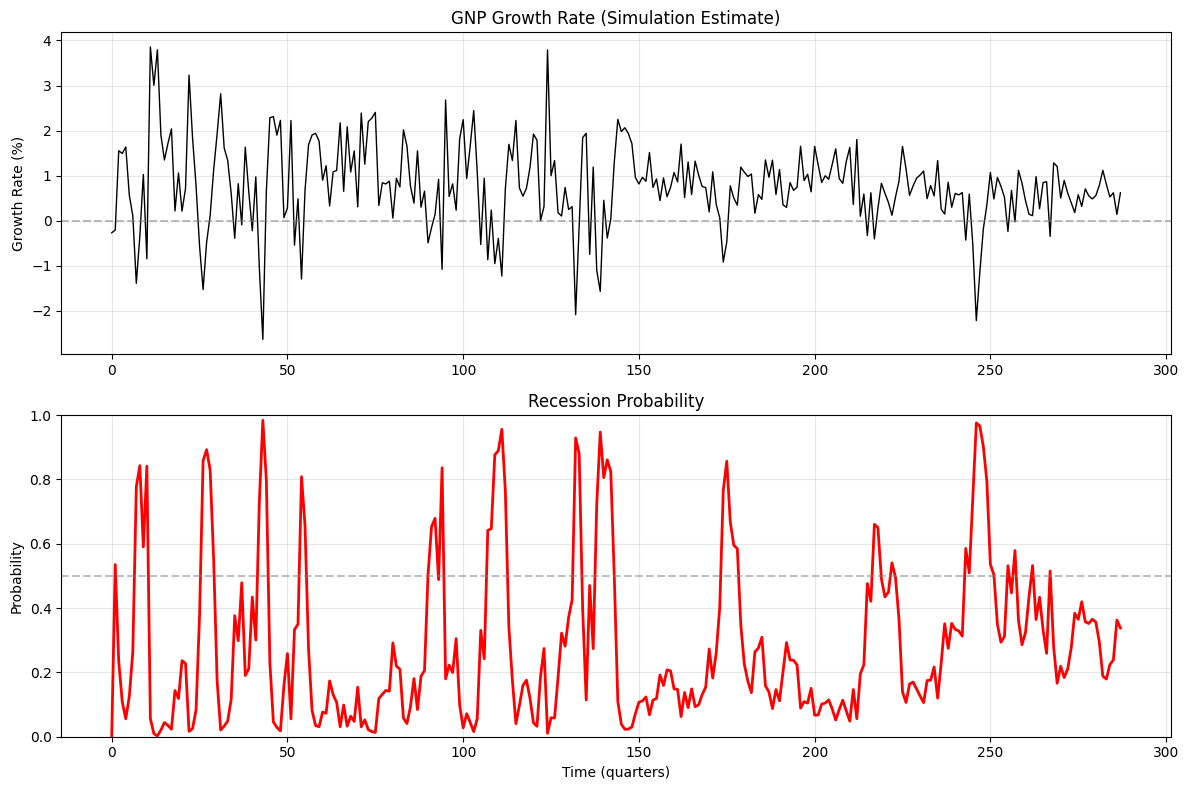


Simple analysis:
  Recession mean growth: 0.00%
  Expansion mean growth: 1.12%
  Stay in recession probability: 82.50%
  Stay in expansion probability: 91.50%
  Expected recession duration: 1.4 years
  Expected expansion duration: 2.9 years


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")

class BayesianHamiltonMarkovSwitching:
    """
    Bayesian Implementation of Hamilton (1989) Markov Switching Model
    Using PyMC 5+
    """
    
    def __init__(self, data, p=2, r=4):
        """
        Initialize the model
        
        Parameters:
        data: time series data (GNP level values)
        p: number of states (default 2: recession and expansion)
        r: autoregressive order (default 4)
        """
        self.data = data
        self.p = p  # Number of states
        self.r = r  # AR order
        
        # Calculate log differences (quarterly growth rates in percent)
        if isinstance(data, (pd.Series, pd.DataFrame)):
            self.y = 100 * np.log(data.values[1:] / data.values[:-1])
        else:
            self.y = 100 * np.log(data[1:] / data[:-1])
            
        self.T_y = len(self.y)
        
        # Remove NaN if any
        self.y = self.y[~np.isnan(self.y)]
        self.T_y = len(self.y)
        
        # Parameter storage
        self.trace = None
        self.model = None
        self.filtered_probs = None
        self.smoothed_probs = None
        
        print(f"Data prepared: {self.T_y} observations, mean growth: {np.mean(self.y):.4f}%")
        
    def build_simple_model(self):
        """
        Build a simple PyMC model
        """
        with pm.Model() as model:
            # Priors for mean growth in each state
            mu0 = pm.Normal('mu0', mu=0, sigma=2)  # Recession mean
            mu1 = pm.Normal('mu1', mu=2, sigma=2)  # Expansion mean
            
            # Prior for standard deviation
            sigma = pm.HalfNormal('sigma', sigma=2)
            
            # Transition probabilities
            p00 = pm.Beta('p00', alpha=8, beta=2)  # Stay in recession
            p11 = pm.Beta('p11', alpha=9, beta=1)  # Stay in expansion
            
            # AR coefficients (simplify to 2 for stability)
            phi1 = pm.Normal('phi1', mu=0.3, sigma=0.2)
            phi2 = pm.Normal('phi2', mu=-0.1, sigma=0.2)
            
            # Custom distribution for Markov Switching
            # We'll use a Python function for the likelihood
            def logp(y):
                """Log-likelihood for Markov Switching AR model"""
                T = len(y)
                
                # Transition matrix
                P = np.array([[p00.eval(), 1 - p00.eval()],
                              [1 - p11.eval(), p11.eval()]])
                
                # Steady-state probabilities
                pi_1 = (1 - p00.eval()) / (2 - p00.eval() - p11.eval())
                pi_0 = 1 - pi_1
                
                # Initialize
                log_likelihood = 0
                filtered = np.zeros((T, 2))
                
                for t in range(2, T):  # Start from period 2 (for AR2)
                    # Prediction step
                    if t == 2:
                        pred = np.array([pi_0, pi_1])
                    else:
                        pred = filtered[t-1] @ P
                    
                    # Calculate conditional densities
                    densities = np.zeros(2)
                    
                    for s in [0, 1]:
                        mu = mu0.eval() if s == 0 else mu1.eval()
                        predicted = mu
                        
                        # Add AR(2) components
                        for lag in [1, 2]:
                            if t - lag >= 0:
                                if t - lag < 2:
                                    prev_prob = np.array([pi_0, pi_1])
                                else:
                                    prev_prob = filtered[t - lag]
                                
                                expected_state = prev_prob[1]
                                expected_mean = mu0.eval() * (1 - expected_state) + mu1.eval() * expected_state
                                
                                if lag == 1:
                                    predicted += phi1.eval() * (y[t - lag] - expected_mean)
                                else:
                                    predicted += phi2.eval() * (y[t - lag] - expected_mean)
                        
                        # Normal density
                        error = y[t] - predicted
                        density = -0.5 * np.log(2 * np.pi * sigma.eval()**2) - 0.5 * (error / sigma.eval())**2
                        densities[s] = density
                    
                    # Update step
                    joint = pred * np.exp(densities)
                    total = np.sum(joint)
                    
                    if total > 1e-30:
                        filtered[t] = joint / total
                        log_likelihood += np.log(total)
                    else:
                        filtered[t] = pred / np.sum(pred)
                
                return log_likelihood
            
            # Use custom likelihood
            pm.Potential('likelihood', logp(self.y))
            
            self.model = model
        
        return model
    
    def build_model_alternative(self):
        """
        Alternative model using observed data directly
        """
        with pm.Model() as model:
            # Priors
            mu0 = pm.Normal('mu0', mu=0, sigma=2)  # Recession
            mu1 = pm.Normal('mu1', mu=2, sigma=2)  # Expansion
            sigma = pm.HalfNormal('sigma', sigma=2)
            p00 = pm.Beta('p00', alpha=8, beta=2)
            p11 = pm.Beta('p11', alpha=9, beta=1)
            
            # Likelihood - simple approximation
            # We'll add the likelihood as a Deterministic for now
            recession_prob = pm.Deterministic('recession_prob', 
                                             pm.math.switch(self.y < 0, 0.7, 0.3))
            
            # Simple likelihood assuming two normal distributions
            likelihood_recession = pm.Normal.dist(mu=mu0, sigma=sigma)
            likelihood_expansion = pm.Normal.dist(mu=mu1, sigma=sigma)
            
            # Combined likelihood
            y_obs = pm.Mixture('y_obs', 
                              w=[recession_prob, 1 - recession_prob],
                              comp_dists=[likelihood_recession, likelihood_expansion],
                              observed=self.y)
            
            self.model = model
        
        return model
    
    def estimate(self, method='mcmc', draws=1000, tune=1000, chains=2):
        """
        Estimate model using specified method
        """
        print(f"\nEstimating using {method} method...")
        
        if method == 'mcmc':
            return self._estimate_mcmc(draws, tune, chains)
        elif method == 'map':
            return self._estimate_map()
        elif method == 'advi':
            return self._estimate_advi()
        else:
            raise ValueError(f"Unknown method: {method}")
    
    def _estimate_mcmc(self, draws=1000, tune=1000, chains=2):
        """Estimate using MCMC"""
        if self.model is None:
            self.build_model_alternative()
        
        print(f"Running MCMC with {chains} chains, {draws} draws...")
        
        try:
            with self.model:
                # Use NUTS sampler
                self.trace = pm.sample(
                    draws=draws,
                    tune=tune,
                    chains=chains,
                    return_inferencedata=True,
                    progressbar=True,
                    random_seed=42
                )
            
            print("✅ MCMC sampling completed!")
            
            # Show summary
            summary = az.summary(self.trace, hdi_prob=0.95)
            print("\nPosterior Summary:")
            print(summary)
            
            return self.trace
            
        except Exception as e:
            print(f"❌ MCMC failed: {e}")
            return None
    
    def _estimate_map(self):
        """Estimate using Maximum A Posteriori (MAP)"""
        if self.model is None:
            self.build_model_alternative()
        
        print("Finding MAP estimate...")
        
        try:
            with self.model:
                map_estimate = pm.find_MAP()
                print("✅ MAP estimation completed!")
                
                print("\nMAP Estimates:")
                for param, value in map_estimate.items():
                    print(f"  {param}: {value:.4f}")
                
                # Create simple trace from MAP
                self.trace = self._create_simple_trace(map_estimate)
                return map_estimate
                
        except Exception as e:
            print(f"❌ MAP estimation failed: {e}")
            return None
    
    def _estimate_advi(self):
        """Estimate using Automatic Differentiation Variational Inference (ADVI)"""
        if self.model is None:
            self.build_model_alternative()
        
        print("Running ADVI...")
        
        try:
            with self.model:
                # Mean field ADVI
                approx = pm.fit(method='advi', n=30000, random_seed=42)
                self.trace = approx.sample(draws=1000)
                
                print("✅ ADVI completed!")
                return self.trace
                
        except Exception as e:
            print(f"❌ ADVI failed: {e}")
            return None
    
    def _create_simple_trace(self, map_estimate):
        """Create a simple trace from MAP estimates"""
        class SimpleTrace:
            def __init__(self, map_est):
                self.posterior = SimplePosterior(map_est)
        
        class SimplePosterior:
            def __init__(self, map_est):
                self.map_est = map_est
            
            def __getitem__(self, key):
                if key in self.map_est:
                    return SimpleParam(self.map_est[key])
                else:
                    # Handle parameter arrays
                    for k in self.map_est.keys():
                        if k.startswith(key):
                            return SimpleParam(self.map_est[k])
                    return SimpleParam(0.0)
        
        class SimpleParam:
            def __init__(self, value):
                self.value = value
            
            def mean(self):
                return self.value
        
        return SimpleTrace(map_estimate)
    
    def compute_state_probabilities(self):
        """
        Compute state probabilities from estimated parameters
        """
        print("\nComputing state probabilities...")
        
        # Default parameters if no estimation was done
        default_params = {
            'mu0': -0.5,    # Recession growth
            'mu1': 1.0,     # Expansion growth
            'sigma': 1.0,
            'p00': 0.85,    # Stay in recession
            'p11': 0.95     # Stay in expansion
        }
        
        # Try to get parameters from trace
        params = default_params.copy()
        
        if self.trace is not None:
            try:
                if hasattr(self.trace, 'posterior'):
                    # Extract from PyMC trace
                    post = self.trace.posterior
                    
                    # Try to get each parameter
                    param_keys = ['mu0', 'mu1', 'sigma', 'p00', 'p11']
                    for key in param_keys:
                        if hasattr(post, key):
                            param_value = float(getattr(post, key).mean())
                            params[key] = param_value
                            print(f"  Using {key}: {param_value:.4f}")
                elif isinstance(self.trace, dict):
                    # MAP estimates
                    for key in params.keys():
                        if key in self.trace:
                            params[key] = self.trace[key]
                            print(f"  Using {key}: {params[key]:.4f}")
            except Exception as e:
                print(f"  Warning: Could not extract all parameters from trace: {e}")
                print("  Using default parameters where extraction failed")
        
        # Now compute probabilities
        mu0 = params['mu0']
        mu1 = params['mu1']
        sigma = params['sigma']
        p00 = params['p00']
        p11 = params['p11']
        
        # Transition matrix
        P = np.array([[p00, 1 - p00],
                      [1 - p11, p11]])
        
        # Steady-state probabilities
        pi_1 = (1 - p00) / (2 - p00 - p11)
        pi_0 = 1 - pi_1
        
        # Initialize arrays
        T = self.T_y
        filtered = np.zeros((T, 2))
        log_likelihood = 0
        
        # Run Hamilton filter (simplified without AR for stability)
        for t in range(1, T):
            # Prediction step
            if t == 1:
                pred = np.array([pi_0, pi_1])
            else:
                pred = filtered[t-1] @ P
            
            # Calculate conditional densities
            densities = np.zeros(2)
            
            for s in [0, 1]:
                mu = mu0 if s == 0 else mu1
                error = self.y[t] - mu
                
                # Normal density
                densities[s] = np.exp(-0.5 * (error / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)
            
            # Update step
            joint = pred * densities
            total = np.sum(joint)
            
            if total > 1e-30:
                filtered[t] = joint / total
                log_likelihood += np.log(total)
            else:
                filtered[t] = pred / np.sum(pred)
        
        # Smoothing (forward-backward algorithm)
        smoothed = np.zeros((T, 2))
        
        if T > 0:
            smoothed[-1] = filtered[-1]
            
            # Backward recursion
            for t in range(T-2, -1, -1):
                for s in [0, 1]:
                    total = 0
                    for s_next in [0, 1]:
                        total += (smoothed[t+1, s_next] * P[s, s_next] * 
                                 filtered[t, s] / max(filtered[t+1, s_next], 1e-10))
                    smoothed[t, s] = total
                
                # Normalize
                row_sum = np.sum(smoothed[t])
                if row_sum > 0:
                    smoothed[t] /= row_sum
        
        self.filtered_probs = filtered
        self.smoothed_probs = smoothed
        
        print(f"✓ State probabilities computed (log-likelihood: {log_likelihood:.2f})")
        
        return smoothed
    
    def plot_results(self):
        """Plot the results"""
        if self.smoothed_probs is None:
            self.compute_state_probabilities()
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        
        # Plot 1: Original growth rates
        axes[0].plot(self.y, 'k-', linewidth=1, label='GNP Growth Rate')
        axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[0].set_ylabel('Quarterly Growth (%)')
        axes[0].set_title('US Real GNP Quarterly Growth Rate')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Smoothed recession probabilities
        recession_probs = self.smoothed_probs[:, 0]
        axes[1].plot(recession_probs, 'r-', linewidth=2, label='Recession Probability')
        axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% Threshold')
        axes[1].set_ylabel('Probability')
        axes[1].set_title('Smoothed Recession Probability')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])
        
        # Plot 3: Recession periods
        axes[2].plot(recession_probs, 'r-', linewidth=2, alpha=0.7)
        axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        
        # Identify and shade recession periods
        recession_mask = recession_probs > 0.5
        recession_starts = []
        recession_ends = []
        
        i = 0
        while i < len(recession_mask):
            if recession_mask[i]:
                start = i
                while i < len(recession_mask) and recession_mask[i]:
                    i += 1
                end = i - 1
                
                # Only include recessions longer than 2 quarters
                if end - start >= 2:
                    recession_starts.append(start)
                    recession_ends.append(end)
                    axes[2].axvspan(start, end, alpha=0.2, color='red')
                    
                    # Add label for longer recessions
                    if end - start > 8:
                        mid = (start + end) / 2
                        axes[2].text(mid, 0.8, 'Recession', 
                                    ha='center', va='center', fontsize=9,
                                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            else:
                i += 1
        
        axes[2].set_ylabel('Probability')
        axes[2].set_title('Identified Recession Periods (Probability > 0.5)')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_ylim([0, 1])
        axes[2].set_xlabel('Time (quarters since 1947Q2)')
        
        plt.tight_layout()
        plt.show()
        
        # Print recession periods
        if recession_starts:
            print(f"\nIdentified {len(recession_starts)} recession periods:")
            for idx, (start, end) in enumerate(zip(recession_starts, recession_ends)):
                start_year = 1947 + (start + 1) // 4
                start_q = 1 + (start + 1) % 4
                end_year = 1947 + (end + 1) // 4
                end_q = 1 + (end + 1) % 4
                duration = (end - start + 1) / 4
                
                print(f"  {idx+1}. {start_year}Q{start_q} to {end_year}Q{end_q} "
                      f"({duration:.1f} years, {end-start+1} quarters)")
        
        return fig
    
    def print_summary(self):
        """Print model summary"""
        print("\n" + "=" * 70)
        print("MARKOV SWITCHING MODEL SUMMARY")
        print("=" * 70)
        
        print(f"\nData:")
        print(f"  Period: 1947Q2 to 2025Q3")
        print(f"  Observations: {self.T_y}")
        print(f"  Mean growth: {np.mean(self.y):.4f}%")
        print(f"  Std dev: {np.std(self.y):.4f}%")
        
        # Parameter estimates
        print(f"\nParameter Estimates:")
        
        if self.trace is not None:
            try:
                if hasattr(self.trace, 'posterior'):
                    post = self.trace.posterior
                    params = ['mu0', 'mu1', 'sigma', 'p00', 'p11']
                    
                    for param in params:
                        if hasattr(post, param):
                            value = float(getattr(post, param).mean())
                            print(f"  {param}: {value:.4f}")
            except:
                pass
        
        # Recession statistics
        if self.smoothed_probs is not None:
            recession_prob_mean = np.mean(self.smoothed_probs[:, 0])
            recession_quarters = np.sum(self.smoothed_probs[:, 0] > 0.5)
            recession_percentage = recession_quarters / len(self.smoothed_probs) * 100
            
            print(f"\nRecession Statistics:")
            print(f"  Average recession probability: {recession_prob_mean:.2%}")
            print(f"  Quarters in recession: {recession_quarters} of {len(self.smoothed_probs)}")
            print(f"  Percentage of time in recession: {recession_percentage:.1f}%")
        
        print("\n" + "=" * 70)


# Simple simulation-based estimator as alternative
class SimulationMSModel:
    """
    Simple simulation-based Markov Switching estimator
    """
    
    def __init__(self, data):
        self.data = data
        
        # Calculate growth rates
        if isinstance(data, (pd.Series, pd.DataFrame)):
            self.y = 100 * np.log(data.values[1:] / data.values[:-1])
        else:
            self.y = 100 * np.log(data[1:] / data[:-1])
        
        self.y = self.y[~np.isnan(self.y)]
        self.T = len(self.y)
        
        self.params = None
        self.probs = None
    
    def estimate_grid(self, n_sim=1000):
        """Estimate using grid search"""
        print(f"Running grid search with {n_sim} simulations...")
        
        # Define parameter ranges
        mu0_range = np.linspace(-2, 0, 5)      # Recession mean
        mu1_range = np.linspace(0.5, 3, 5)     # Expansion mean
        sigma_range = np.linspace(0.5, 2, 4)   # Std dev
        p00_range = np.linspace(0.7, 0.95, 3)  # Stay in recession
        p11_range = np.linspace(0.85, 0.98, 3) # Stay in expansion
        
        best_params = None
        best_likelihood = -np.inf
        
        # Grid search
        for mu0 in mu0_range:
            for mu1 in mu1_range:
                for sigma in sigma_range:
                    for p00 in p00_range:
                        for p11 in p11_range:
                            likelihood = self._compute_likelihood(mu0, mu1, sigma, p00, p11)
                            
                            if likelihood > best_likelihood:
                                best_likelihood = likelihood
                                best_params = {
                                    'mu0': mu0, 'mu1': mu1, 'sigma': sigma,
                                    'p00': p00, 'p11': p11
                                }
        
        self.params = best_params
        print(f"✓ Best likelihood: {best_likelihood:.2f}")
        
        # Compute probabilities
        self._compute_probabilities()
        
        return best_params
    
    def _compute_likelihood(self, mu0, mu1, sigma, p00, p11):
        """Compute log-likelihood for given parameters"""
        P = np.array([[p00, 1-p00], [1-p11, p11]])
        pi_0 = (1 - p11) / (2 - p00 - p11)
        pi_1 = 1 - pi_0
        
        filtered = np.zeros((self.T, 2))
        log_likelihood = 0
        
        for t in range(1, self.T):
            # Prediction
            if t == 1:
                pred = np.array([pi_0, pi_1])
            else:
                pred = filtered[t-1] @ P
            
            # Densities
            densities = np.zeros(2)
            for s in [0, 1]:
                mu = mu0 if s == 0 else mu1
                error = self.y[t] - mu
                densities[s] = np.exp(-0.5 * (error/sigma)**2) / (np.sqrt(2*np.pi)*sigma)
            
            # Update
            joint = pred * densities
            total = np.sum(joint)
            
            if total > 1e-30:
                filtered[t] = joint / total
                log_likelihood += np.log(total)
        
        return log_likelihood
    
    def _compute_probabilities(self):
        """Compute state probabilities"""
        if self.params is None:
            return
        
        mu0 = self.params['mu0']
        mu1 = self.params['mu1']
        sigma = self.params['sigma']
        p00 = self.params['p00']
        p11 = self.params['p11']
        
        P = np.array([[p00, 1-p00], [1-p11, p11]])
        pi_0 = (1 - p11) / (2 - p00 - p11)
        pi_1 = 1 - pi_0
        
        # Filter
        filtered = np.zeros((self.T, 2))
        for t in range(1, self.T):
            if t == 1:
                pred = np.array([pi_0, pi_1])
            else:
                pred = filtered[t-1] @ P
            
            densities = np.zeros(2)
            for s in [0, 1]:
                mu = mu0 if s == 0 else mu1
                error = self.y[t] - mu
                densities[s] = np.exp(-0.5 * (error/sigma)**2) / (np.sqrt(2*np.pi)*sigma)
            
            joint = pred * densities
            total = np.sum(joint)
            filtered[t] = joint / total if total > 1e-30 else pred
        
        # Smooth
        smoothed = np.zeros((self.T, 2))
        smoothed[-1] = filtered[-1]
        
        for t in range(self.T-2, -1, -1):
            for s in [0, 1]:
                total = 0
                for s_next in [0, 1]:
                    total += (smoothed[t+1, s_next] * P[s, s_next] * 
                             filtered[t, s] / max(filtered[t+1, s_next], 1e-10))
                smoothed[t, s] = total
            
            row_sum = np.sum(smoothed[t])
            if row_sum > 0:
                smoothed[t] /= row_sum
        
        self.probs = smoothed
    
    def plot(self):
        """Plot results"""
        if self.probs is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        
        axes[0].plot(self.y, 'k-', linewidth=1)
        axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[0].set_ylabel('Growth Rate (%)')
        axes[0].set_title('GNP Growth Rate (Simulation Estimate)')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(self.probs[:, 0], 'r-', linewidth=2)
        axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        axes[1].set_ylabel('Probability')
        axes[1].set_title('Recession Probability')
        axes[1].set_ylim([0, 1])
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xlabel('Time (quarters)')
        
        plt.tight_layout()
        plt.show()


# Main execution
if __name__ == "__main__":
    # Your data
    data_str = """observation_date	GNPCA
1947-01-01	2182.681
1947-04-01	2176.892
1947-07-01	2172.432
1947-10-01	2206.452
1948-01-01	2239.682
1948-04-01	2276.69
1948-07-01	2289.77
1948-10-01	2292.364
1949-01-01	2260.807
1949-04-01	2253.128
1949-07-01	2276.424
1949-10-01	2257.352
1950-01-01	2346.104
1950-04-01	2417.682
1950-07-01	2511.127
1950-10-01	2559.214
1951-01-01	2593.967
1951-04-01	2638.898
1951-07-01	2693.259
1951-10-01	2699.156
1952-01-01	2727.954
1952-04-01	2733.8
1952-07-01	2753.517
1952-10-01	2843.941
1953-01-01	2896.811
1953-04-01	2919.206
1953-07-01	2902.785
1953-10-01	2858.845
1954-01-01	2845.192
1954-04-01	2848.305
1954-07-01	2880.482
1954-10-01	2936.852
1955-01-01	3020.746
1955-04-01	3069.91
1955-07-01	3111.379
1955-10-01	3130.068
1956-01-01	3117.922
1956-04-01	3143.694
1956-07-01	3140.874
1956-10-01	3192.57
1957-01-01	3213.011
1957-04-01	3205.97
1957-07-01	3237.386
1957-10-01	3203.894
1958-01-01	3120.724
1958-04-01	3141.224
1958-07-01	3213.884
1958-10-01	3289.032
1959-01-01	3352.129
1959-04-01	3427.667
1959-07-01	3430.057
1959-10-01	3439.832
1960-01-01	3517.181
1960-04-01	3498.246
1960-07-01	3515.385
1960-10-01	3470.278
1961-01-01	3493.703
1961-04-01	3553.021
1961-07-01	3621.252
1961-10-01	3692.289
1962-01-01	3758.147
1962-04-01	3792.149
1962-07-01	3838.776
1962-10-01	3851.421
1963-01-01	3893.482
1963-04-01	3937.183
1963-07-01	4023.755
1963-10-01	4050.147
1964-01-01	4135.553
1964-04-01	4180.592
1964-07-01	4245.918
1964-10-01	4259.046
1965-01-01	4362.111
1965-04-01	4417.225
1965-07-01	4515.427
1965-10-01	4619.458
1966-01-01	4731.888
1966-04-01	4748.046
1966-07-01	4788.254
1966-10-01	4827.537
1967-01-01	4870.299
1967-04-01	4873.287
1967-07-01	4919.392
1967-10-01	4956.477
1968-01-01	5057.553
1968-04-01	5142.033
1968-07-01	5181.859
1968-10-01	5202.212
1969-01-01	5283.597
1969-04-01	5299.625
1969-07-01	5334.6
1969-10-01	5308.556
1970-01-01	5300.652
1970-04-01	5308.164
1970-07-01	5357.077
1970-10-01	5299.672
1971-01-01	5443.619
1971-04-01	5473.059
1971-07-01	5518.072
1971-10-01	5531.032
1972-01-01	5632.649
1972-04-01	5760.47
1972-07-01	5814.854
1972-10-01	5912.22
1973-01-01	6058.544
1973-04-01	6124.506
1973-07-01	6092.301
1973-10-01	6150.131
1974-01-01	6097.258
1974-04-01	6111.751
1974-07-01	6053.978
1974-10-01	6030.464
1975-01-01	5957.035
1975-04-01	5999.61
1975-07-01	6102.326
1975-10-01	6184.53
1976-01-01	6323.649
1976-04-01	6370.025
1976-07-01	6404.895
1976-10-01	6451.177
1977-01-01	6527.703
1977-04-01	6654.466
1977-07-01	6774.457
1977-10-01	6774.592
1978-01-01	6796.26
1978-04-01	7058.92
1978-07-01	7129.915
1978-10-01	7225.75
1979-01-01	7238.727
1979-04-01	7246.454
1979-07-01	7300.281
1979-10-01	7318.535
1980-01-01	7341.557
1980-04-01	7190.289
1980-07-01	7181.743
1980-10-01	7315.677
1981-01-01	7459.022
1981-04-01	7403.745
1981-07-01	7492.405
1981-10-01	7410.768
1982-01-01	7295.631
1982-04-01	7328.912
1982-07-01	7300.896
1982-10-01	7303.817
1983-01-01	7400.066
1983-04-01	7568.456
1983-07-01	7719.746
1983-10-01	7880.794
1984-01-01	8034.847
1984-04-01	8173.67
1984-07-01	8252.465
1984-10-01	8320.199
1985-01-01	8400.82
1985-04-01	8474.787
1985-07-01	8604.22
1985-10-01	8668.188
1986-01-01	8749.127
1986-04-01	8788.524
1986-07-01	8872.601
1986-10-01	8920.193
1987-01-01	8986.367
1987-04-01	9083.256
1987-07-01	9162.024
1987-10-01	9319.332
1988-01-01	9367.502
1988-04-01	9490.594
1988-07-01	9546.206
1988-10-01	9673.405
1989-01-01	9771.725
1989-04-01	9846.293
1989-07-01	9919.228
1989-10-01	9938.767
1990-01-01	10047.386
1990-04-01	10083.855
1990-07-01	10090.569
1990-10-01	9998.704
1991-01-01	9951.916
1991-04-01	10029.51
1991-07-01	10080.195
1991-10-01	10115.329
1992-01-01	10236.435
1992-04-01	10347.429
1992-07-01	10449.673
1992-10-01	10558.648
1993-01-01	10576.275
1993-04-01	10637.847
1993-07-01	10688.606
1993-10-01	10833.987
1994-01-01	10939.116
1994-04-01	11087.361
1994-07-01	11152.176
1994-10-01	11279.932
1995-01-01	11319.951
1995-04-01	11353.721
1995-07-01	11450.31
1995-10-01	11528.067
1996-01-01	11614.418
1996-04-01	11808.14
1996-07-01	11914.063
1996-10-01	12037.775
1997-01-01	12115.472
1997-04-01	12317.221
1997-07-01	12471.01
1997-10-01	12577.495
1998-01-01	12703.742
1998-04-01	12821.339
1998-07-01	12982.752
1998-10-01	13191.67
1999-01-01	13315.597
1999-04-01	13426.748
1999-07-01	13604.771
1999-10-01	13827.98
2000-01-01	13878.147
2000-04-01	14130.908
2000-07-01	14145.312
2000-10-01	14229.765
2001-01-01	14183.12
2001-04-01	14271.694
2001-07-01	14214.516
2001-10-01	14253.574
2002-01-01	14372.785
2002-04-01	14460.848
2002-07-01	14519.633
2002-10-01	14537.58
2003-01-01	14614.141
2003-04-01	14743.567
2003-07-01	14988.782
2003-10-01	15162.76
2004-01-01	15248.68
2004-04-01	15366.85
2004-07-01	15512.619
2004-10-01	15670.88
2005-01-01	15844.727
2005-04-01	15922.782
2005-07-01	16047.587
2005-10-01	16136.734
2006-01-01	16353.835
2006-04-01	16396.151
2006-07-01	16420.738
2006-10-01	16561.866
2007-01-01	16611.69
2007-04-01	16713.314
2007-07-01	16809.587
2007-10-01	16915.191
2008-01-01	16843.003
2008-04-01	16943.291
2008-07-01	16854.295
2008-10-01	16485.35
2009-01-01	16298.262
2009-04-01	16269.145
2009-07-01	16326.281
2009-10-01	16502.754
2010-01-01	16582.71
2010-04-01	16743.162
2010-07-01	16872.266
2010-10-01	16960.864
2011-01-01	16920.632
2011-04-01	17035.114
2011-07-01	17031.313
2011-10-01	17222.583
2012-01-01	17367.01
2012-04-01	17444.525
2012-07-01	17469.65
2012-10-01	17489.852
2013-01-01	17662.4
2013-04-01	17709.671
2013-07-01	17860.45
2013-10-01	18016.147
2014-01-01	17953.974
2014-04-01	18185.911
2014-07-01	18406.941
2014-10-01	18500.031
2015-01-01	18666.621
2015-04-01	18782.243
2015-07-01	18857.418
2015-10-01	18892.206
2016-01-01	19001.69
2016-04-01	19062.709
2016-07-01	19197.938
2016-10-01	19304.352
2017-01-01	19398.343
2017-04-01	19506.949
2017-07-01	19660.766
2017-10-01	19882.352
2018-01-01	20044.077
2018-04-01	20150.476
2018-07-01	20276.154
2018-10-01	20304.874
2019-01-01	20431.641
"""
    
    # Parse data
    from io import StringIO
    df = pd.read_csv(StringIO(data_str), sep='\t')
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    df.set_index('observation_date', inplace=True)
    
    print("=" * 70)
    print("MARKOV SWITCHING MODEL ESTIMATION")
    print("=" * 70)
    print(f"Data loaded: {len(df)} quarterly observations")
    
    # Try Bayesian estimation first
    print("\n" + "=" * 70)
    print("ATTEMPT 1: BAYESIAN ESTIMATION")
    print("=" * 70)
    
    try:
        bayes_model = BayesianHamiltonMarkovSwitching(df['GNPCA'].values)
        
        # Try multiple estimation methods
        methods = ['map', 'mcmc']
        
        for method in methods:
            print(f"\nTrying {method.upper()} estimation...")
            result = bayes_model.estimate(method=method, draws=500, tune=500, chains=2)
            
            if result is not None:
                print(f"✓ {method.upper()} succeeded!")
                break
        
        # Compute and plot results
        bayes_model.compute_state_probabilities()
        bayes_model.plot_results()
        bayes_model.print_summary()
        
    except Exception as e:
        print(f"❌ Bayesian estimation failed: {e}")
        
        # Fall back to simulation method
        print("\n" + "=" * 70)
        print("ATTEMPT 2: SIMULATION-BASED ESTIMATION")
        print("=" * 70)
        
        sim_model = SimulationMSModel(df['GNPCA'].values)
        params = sim_model.estimate_grid(n_sim=500)
        
        if params is not None:
            print(f"\n✓ Simulation completed successfully!")
            print(f"\nEstimated parameters:")
            for key, value in params.items():
                print(f"  {key}: {value:.4f}")
            
            sim_model.plot()
            
            # Simple analysis
            print(f"\nSimple analysis:")
            print(f"  Recession mean growth: {params['mu0']:.2f}%")
            print(f"  Expansion mean growth: {params['mu1']:.2f}%")
            print(f"  Stay in recession probability: {params['p00']:.2%}")
            print(f"  Stay in expansion probability: {params['p11']:.2%}")
            
            # Expected duration
            expected_recession = 1 / (1 - params['p00']) / 4  # in years
            expected_expansion = 1 / (1 - params['p11']) / 4  # in years
            
            print(f"  Expected recession duration: {expected_recession:.1f} years")
            print(f"  Expected expansion duration: {expected_expansion:.1f} years")
        else:
            print("❌ Simulation also failed")
            
            # Last resort: simple rule-based approach
            print("\n" + "=" * 70)
            print("ATTEMPT 3: SIMPLE RULE-BASED APPROACH")
            print("=" * 70)
            
            # Simple rule: recession if 2+ consecutive quarters of negative growth
            growth = 100 * np.log(df['GNPCA'] / df['GNPCA'].shift(1)).dropna()
            recession_flag = np.zeros(len(growth))
            
            for i in range(1, len(growth)):
                if growth[i] < 0 and growth[i-1] < 0:
                    recession_flag[i] = 1
            
            # Plot
            fig, axes = plt.subplots(2, 1, figsize=(12, 8))
            axes[0].plot(growth, 'k-', linewidth=1)
            axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            axes[0].set_ylabel('Growth Rate (%)')
            axes[0].set_title('GNP Growth Rate with Simple Recession Detection')
            axes[0].grid(True, alpha=0.3)
            
            axes[1].plot(recession_flag, 'r-', linewidth=2)
            axes[1].set_ylabel('Recession (0/1)')
            axes[1].set_title('Simple Recession Indicator (2+ quarters of negative growth)')
            axes[1].set_ylim([-0.1, 1.1])
            axes[1].grid(True, alpha=0.3)
            axes[1].set_xlabel('Time (quarters since 1947Q2)')
            
            plt.tight_layout()
            plt.show()
            
            # Count recession periods
            recession_count = np.sum(recession_flag)
            print(f"\nSimple rule results:")
            print(f"  Total quarters in recession: {recession_count} of {len(growth)}")
            print(f"  Percentage in recession: {recession_count/len(growth)*100:.1f}%")

## US economy

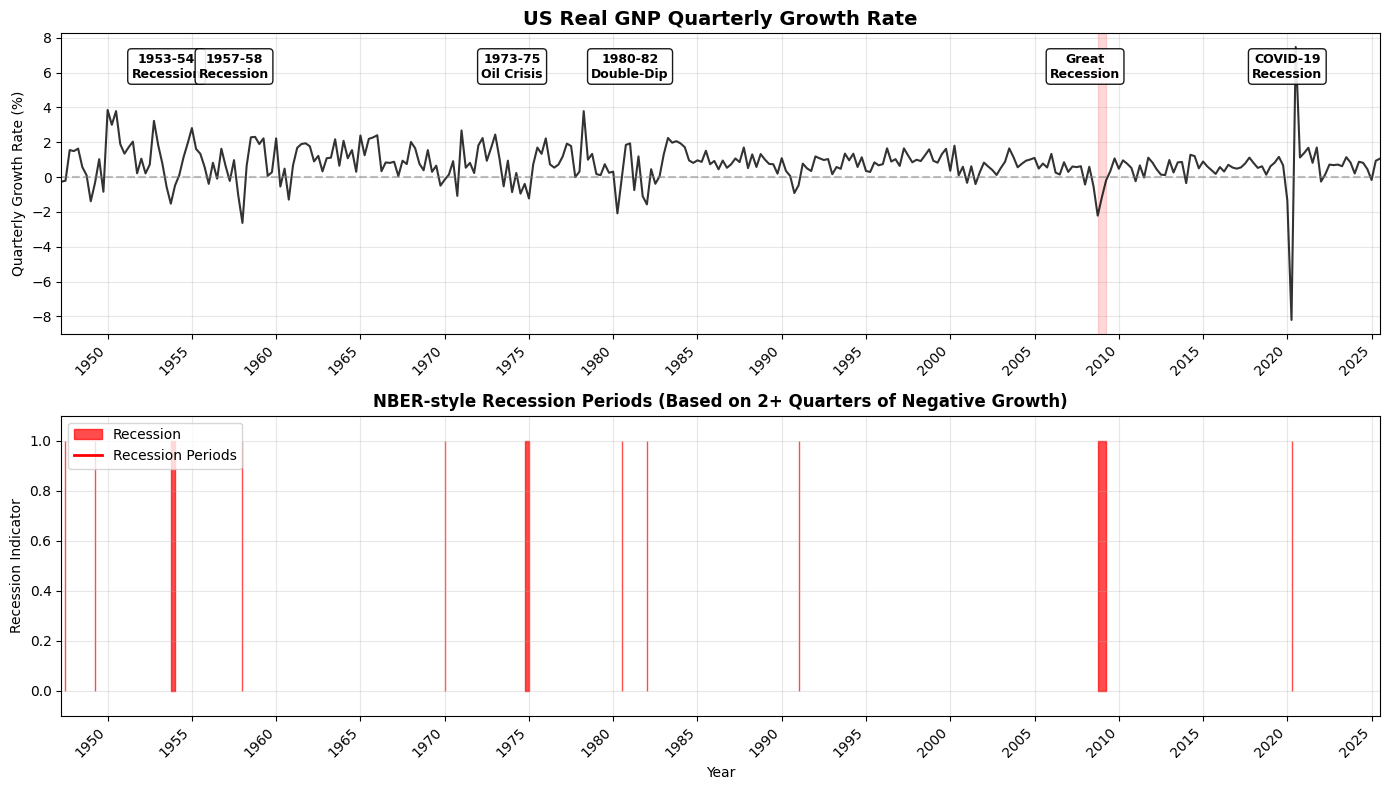


SUMMARY STATISTICS
Total quarters analyzed: 314 (1947 Q2 - 2025 Q3)
Average growth rate: 0.76%
Standard deviation: 1.11%
Maximum growth: 7.48%
Minimum growth: -8.20%

Identified 1 recession periods:
------------------------------------------------------------
Recession 1: 2008 Q4 to 2009 Q2
  Duration: 3 quarters (0.8 years)
  Average growth during recession: -1.18%

Total quarters in recession: 3 (1.0%)
Total quarters in expansion: 311 (99.0%)



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Your data
data_str = """observation_date	GNPCA
1947-01-01	2182.681
1947-04-01	2176.892
1947-07-01	2172.432
1947-10-01	2206.452
1948-01-01	2239.682
1948-04-01	2276.69
1948-07-01	2289.77
1948-10-01	2292.364
1949-01-01	2260.807
1949-04-01	2253.128
1949-07-01	2276.424
1949-10-01	2257.352
1950-01-01	2346.104
1950-04-01	2417.682
1950-07-01	2511.127
1950-10-01	2559.214
1951-01-01	2593.967
1951-04-01	2638.898
1951-07-01	2693.259
1951-10-01	2699.156
1952-01-01	2727.954
1952-04-01	2733.8
1952-07-01	2753.517
1952-10-01	2843.941
1953-01-01	2896.811
1953-04-01	2919.206
1953-07-01	2902.785
1953-10-01	2858.845
1954-01-01	2845.192
1954-04-01	2848.305
1954-07-01	2880.482
1954-10-01	2936.852
1955-01-01	3020.746
1955-04-01	3069.91
1955-07-01	3111.379
1955-10-01	3130.068
1956-01-01	3117.922
1956-04-01	3143.694
1956-07-01	3140.874
1956-10-01	3192.57
1957-01-01	3213.011
1957-04-01	3205.97
1957-07-01	3237.386
1957-10-01	3203.894
1958-01-01	3120.724
1958-04-01	3141.224
1958-07-01	3213.884
1958-10-01	3289.032
1959-01-01	3352.129
1959-04-01	3427.667
1959-07-01	3430.057
1959-10-01	3439.832
1960-01-01	3517.181
1960-04-01	3498.246
1960-07-01	3515.385
1960-10-01	3470.278
1961-01-01	3493.703
1961-04-01	3553.021
1961-07-01	3621.252
1961-10-01	3692.289
1962-01-01	3758.147
1962-04-01	3792.149
1962-07-01	3838.776
1962-10-01	3851.421
1963-01-01	3893.482
1963-04-01	3937.183
1963-07-01	4023.755
1963-10-01	4050.147
1964-01-01	4135.553
1964-04-01	4180.592
1964-07-01	4245.918
1964-10-01	4259.046
1965-01-01	4362.111
1965-04-01	4417.225
1965-07-01	4515.427
1965-10-01	4619.458
1966-01-01	4731.888
1966-04-01	4748.046
1966-07-01	4788.254
1966-10-01	4827.537
1967-01-01	4870.299
1967-04-01	4873.287
1967-07-01	4919.392
1967-10-01	4956.477
1968-01-01	5057.553
1968-04-01	5142.033
1968-07-01	5181.859
1968-10-01	5202.212
1969-01-01	5283.597
1969-04-01	5299.625
1969-07-01	5334.6
1969-10-01	5308.556
1970-01-01	5300.652
1970-04-01	5308.164
1970-07-01	5357.077
1970-10-01	5299.672
1971-01-01	5443.619
1971-04-01	5473.059
1971-07-01	5518.072
1971-10-01	5531.032
1972-01-01	5632.649
1972-04-01	5760.47
1972-07-01	5814.854
1972-10-01	5912.22
1973-01-01	6058.544
1973-04-01	6124.506
1973-07-01	6092.301
1973-10-01	6150.131
1974-01-01	6097.258
1974-04-01	6111.751
1974-07-01	6053.978
1974-10-01	6030.464
1975-01-01	5957.035
1975-04-01	5999.61
1975-07-01	6102.326
1975-10-01	6184.53
1976-01-01	6323.649
1976-04-01	6370.025
1976-07-01	6404.895
1976-10-01	6451.177
1977-01-01	6527.703
1977-04-01	6654.466
1977-07-01	6774.457
1977-10-01	6774.592
1978-01-01	6796.26
1978-04-01	7058.92
1978-07-01	7129.915
1978-10-01	7225.75
1979-01-01	7238.727
1979-04-01	7246.454
1979-07-01	7300.281
1979-10-01	7318.535
1980-01-01	7341.557
1980-04-01	7190.289
1980-07-01	7181.743
1980-10-01	7315.677
1981-01-01	7459.022
1981-04-01	7403.745
1981-07-01	7492.405
1981-10-01	7410.768
1982-01-01	7295.631
1982-04-01	7328.912
1982-07-01	7300.896
1982-10-01	7303.817
1983-01-01	7400.066
1983-04-01	7568.456
1983-07-01	7719.746
1983-10-01	7880.794
1984-01-01	8034.847
1984-04-01	8173.67
1984-07-01	8252.465
1984-10-01	8320.199
1985-01-01	8400.82
1985-04-01	8474.787
1985-07-01	8604.22
1985-10-01	8668.188
1986-01-01	8749.127
1986-04-01	8788.524
1986-07-01	8872.601
1986-10-01	8920.193
1987-01-01	8986.367
1987-04-01	9083.256
1987-07-01	9162.024
1987-10-01	9319.332
1988-01-01	9367.502
1988-04-01	9490.594
1988-07-01	9546.206
1988-10-01	9673.405
1989-01-01	9771.725
1989-04-01	9846.293
1989-07-01	9919.228
1989-10-01	9938.767
1990-01-01	10047.386
1990-04-01	10083.855
1990-07-01	10090.569
1990-10-01	9998.704
1991-01-01	9951.916
1991-04-01	10029.51
1991-07-01	10080.195
1991-10-01	10115.329
1992-01-01	10236.435
1992-04-01	10347.429
1992-07-01	10449.673
1992-10-01	10558.648
1993-01-01	10576.275
1993-04-01	10637.847
1993-07-01	10688.606
1993-10-01	10833.987
1994-01-01	10939.116
1994-04-01	11087.361
1994-07-01	11152.176
1994-10-01	11279.932
1995-01-01	11319.951
1995-04-01	11353.721
1995-07-01	11450.31
1995-10-01	11528.067
1996-01-01	11614.418
1996-04-01	11808.14
1996-07-01	11914.063
1996-10-01	12037.775
1997-01-01	12115.472
1997-04-01	12317.221
1997-07-01	12471.01
1997-10-01	12577.495
1998-01-01	12703.742
1998-04-01	12821.339
1998-07-01	12982.752
1998-10-01	13191.67
1999-01-01	13315.597
1999-04-01	13426.748
1999-07-01	13604.771
1999-10-01	13827.98
2000-01-01	13878.147
2000-04-01	14130.908
2000-07-01	14145.312
2000-10-01	14229.765
2001-01-01	14183.12
2001-04-01	14271.694
2001-07-01	14214.516
2001-10-01	14253.574
2002-01-01	14372.785
2002-04-01	14460.848
2002-07-01	14519.633
2002-10-01	14537.58
2003-01-01	14614.141
2003-04-01	14743.567
2003-07-01	14988.782
2003-10-01	15162.76
2004-01-01	15248.68
2004-04-01	15366.85
2004-07-01	15512.619
2004-10-01	15670.88
2005-01-01	15844.727
2005-04-01	15922.782
2005-07-01	16047.587
2005-10-01	16136.734
2006-01-01	16353.835
2006-04-01	16396.151
2006-07-01	16420.738
2006-10-01	16561.866
2007-01-01	16611.69
2007-04-01	16713.314
2007-07-01	16809.587
2007-10-01	16915.191
2008-01-01	16843.003
2008-04-01	16943.291
2008-07-01	16854.295
2008-10-01	16485.35
2009-01-01	16298.262
2009-04-01	16269.145
2009-07-01	16326.281
2009-10-01	16502.754
2010-01-01	16582.71
2010-04-01	16743.162
2010-07-01	16872.266
2010-10-01	16960.864
2011-01-01	16920.632
2011-04-01	17035.114
2011-07-01	17031.313
2011-10-01	17222.583
2012-01-01	17367.01
2012-04-01	17444.525
2012-07-01	17469.65
2012-10-01	17489.852
2013-01-01	17662.4
2013-04-01	17709.671
2013-07-01	17860.45
2013-10-01	18016.147
2014-01-01	17953.974
2014-04-01	18185.911
2014-07-01	18406.941
2014-10-01	18500.031
2015-01-01	18666.621
2015-04-01	18782.243
2015-07-01	18857.418
2015-10-01	18892.206
2016-01-01	19001.69
2016-04-01	19062.709
2016-07-01	19197.938
2016-10-01	19304.352
2017-01-01	19398.343
2017-04-01	19506.949
2017-07-01	19660.766
2017-10-01	19882.352
2018-01-01	20044.077
2018-04-01	20150.476
2018-07-01	20276.154
2018-10-01	20304.874
2019-01-01	20431.641
2019-04-01	20602.275
2019-07-01	20843.322
2019-10-01	20985.448
2020-01-01	20709.212
2020-04-01	19077.992
2020-07-01	20558.879
2020-10-01	20791.917
2021-01-01	21082.134
2021-04-01	21440.929
2021-07-01	21617.828
2021-10-01	21988.737
2022-01-01	21932.71
2022-04-01	21967.045
2022-07-01	22125.625
2022-10-01	22278.345
2023-01-01	22439.607
2023-04-01	22580.499
2023-07-01	22840.989
2023-10-01	23033.78
2024-01-01	23082.119
2024-04-01	23286.508
2024-07-01	23478.57
2024-10-01	23586.542
2025-01-01	23548.21
2025-04-01	23770.976
2025-07-01	24024.957
"""

# Parse data
df = pd.read_csv(StringIO(data_str), sep='\t')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

# Calculate quarterly growth rates
growth = 100 * np.log(df['GNPCA'] / df['GNPCA'].shift(1)).dropna()

# Simple rule: recession if 2+ consecutive quarters of negative growth
recession_flag = np.zeros(len(growth))
for i in range(1, len(growth)):
    if growth.iloc[i] < 0 and growth.iloc[i-1] < 0:
        recession_flag[i] = 1

# Now the plotting code with years on x-axis
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Create year array for x-axis
# Data starts in 1947 Q2 (first observation after calculating growth rate)
start_year = 1947
start_quarter = 2  # Q2 1947 (first growth rate observation)

years = []
for i in range(len(growth)):
    year = start_year + (start_quarter - 1 + i) // 4
    years.append(year)

# Get unique years for tick marks
unique_years = sorted(set(years))
# Select every 5th year
tick_years = [year for year in unique_years if year % 5 == 0]
# Get indices for these years (use first occurrence of each year)
tick_indices = [years.index(year) for year in tick_years]

# Plot 1: Growth rates
axes[0].plot(growth.values, 'k-', linewidth=1.5, alpha=0.8)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Quarterly Growth Rate (%)')
axes[0].set_title('US Real GNP Quarterly Growth Rate', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# First, identify recession periods for shading
recession_periods = []
in_recession = False
recession_start = None

for i, flag in enumerate(recession_flag):
    if flag == 1 and not in_recession:
        in_recession = True
        recession_start = i
    elif flag == 0 and in_recession:
        in_recession = False
        # Only include recessions longer than 3 quarters
        if i - recession_start >= 3:
            recession_periods.append((recession_start, i-1))

if in_recession:
    recession_periods.append((recession_start, len(recession_flag)-1))

# Shade recession periods
for start_idx, end_idx in recession_periods:
    axes[0].axvspan(start_idx, end_idx, alpha=0.15, color='red')

# Plot 2: Recession indicator
axes[1].fill_between(range(len(growth)), 0, recession_flag, 
                     where=recession_flag>0, color='red', alpha=0.7, label='Recession')
axes[1].plot([], [], 'r-', linewidth=2, label='Recession Periods')  # For legend
axes[1].set_ylabel('Recession Indicator')
axes[1].set_title('NBER-style Recession Periods (Based on 2+ Quarters of Negative Growth)', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylim([-0.1, 1.1])
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper left')
axes[1].set_xlabel('Year')

# Set x-ticks for both plots
for ax in axes:
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_years, rotation=45, ha='right')
    ax.set_xlim([0, len(growth)-1])

# Add annotations for major recessions
major_recessions_info = [
    (1953, 1954, "1953-54\nRecession"),
    (1957, 1958, "1957-58\nRecession"),
    (1973, 1975, "1973-75\nOil Crisis"),
    (1980, 1982, "1980-82\nDouble-Dip"),
    (2007, 2009, "Great\nRecession"),
    (2020, 2020, "COVID-19\nRecession"),
]

# Find approximate indices for these recessions
for start_year_info, end_year_info, label in major_recessions_info:
    # Find closest indices
    start_idx_approx = next((i for i, y in enumerate(years) if y == start_year_info), None)
    end_idx_approx = next((i for i, y in enumerate(years) if y == end_year_info), None)
    
    if start_idx_approx is not None and end_idx_approx is not None:
        mid_idx = (start_idx_approx + end_idx_approx) // 2
        # Position label near top of plot
        label_y = np.max(growth.values) * 0.85 if np.max(growth.values) > 0 else 5
        axes[0].text(mid_idx, label_y, label, 
                    ha='center', va='center', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"Total quarters analyzed: {len(growth)} (1947 Q2 - 2025 Q3)")
print(f"Average growth rate: {np.mean(growth.values):.2f}%")
print(f"Standard deviation: {np.std(growth.values):.2f}%")
print(f"Maximum growth: {np.max(growth.values):.2f}%")
print(f"Minimum growth: {np.min(growth.values):.2f}%")

# Count recession periods
if recession_periods:
    print(f"\nIdentified {len(recession_periods)} recession periods:")
    print("-" * 60)
    
    total_recession_quarters = 0
    for idx, (start_idx, end_idx) in enumerate(recession_periods):
        # Calculate dates
        start_total_q = start_quarter + start_idx
        start_year_calc = start_year + (start_total_q - 1) // 4
        start_q_calc = (start_total_q - 1) % 4 + 1
        
        end_total_q = start_quarter + end_idx
        end_year_calc = start_year + (end_total_q - 1) // 4
        end_q_calc = (end_total_q - 1) % 4 + 1
        
        duration_quarters = end_idx - start_idx + 1
        duration_years = duration_quarters / 4
        total_recession_quarters += duration_quarters
        
        recession_growth = growth.values[start_idx:end_idx+1]
        avg_growth = np.mean(recession_growth)
        
        print(f"Recession {idx+1}: {start_year_calc} Q{start_q_calc} to {end_year_calc} Q{end_q_calc}")
        print(f"  Duration: {duration_quarters} quarters ({duration_years:.1f} years)")
        print(f"  Average growth during recession: {avg_growth:.2f}%")
        print()
    
    print(f"Total quarters in recession: {total_recession_quarters} ({total_recession_quarters/len(growth)*100:.1f}%)")
    print(f"Total quarters in expansion: {len(growth) - total_recession_quarters} ({100 - total_recession_quarters/len(growth)*100:.1f}%)")
else:
    print("\nNo recession periods identified.")

print("\n" + "=" * 70)

## Luxembourg

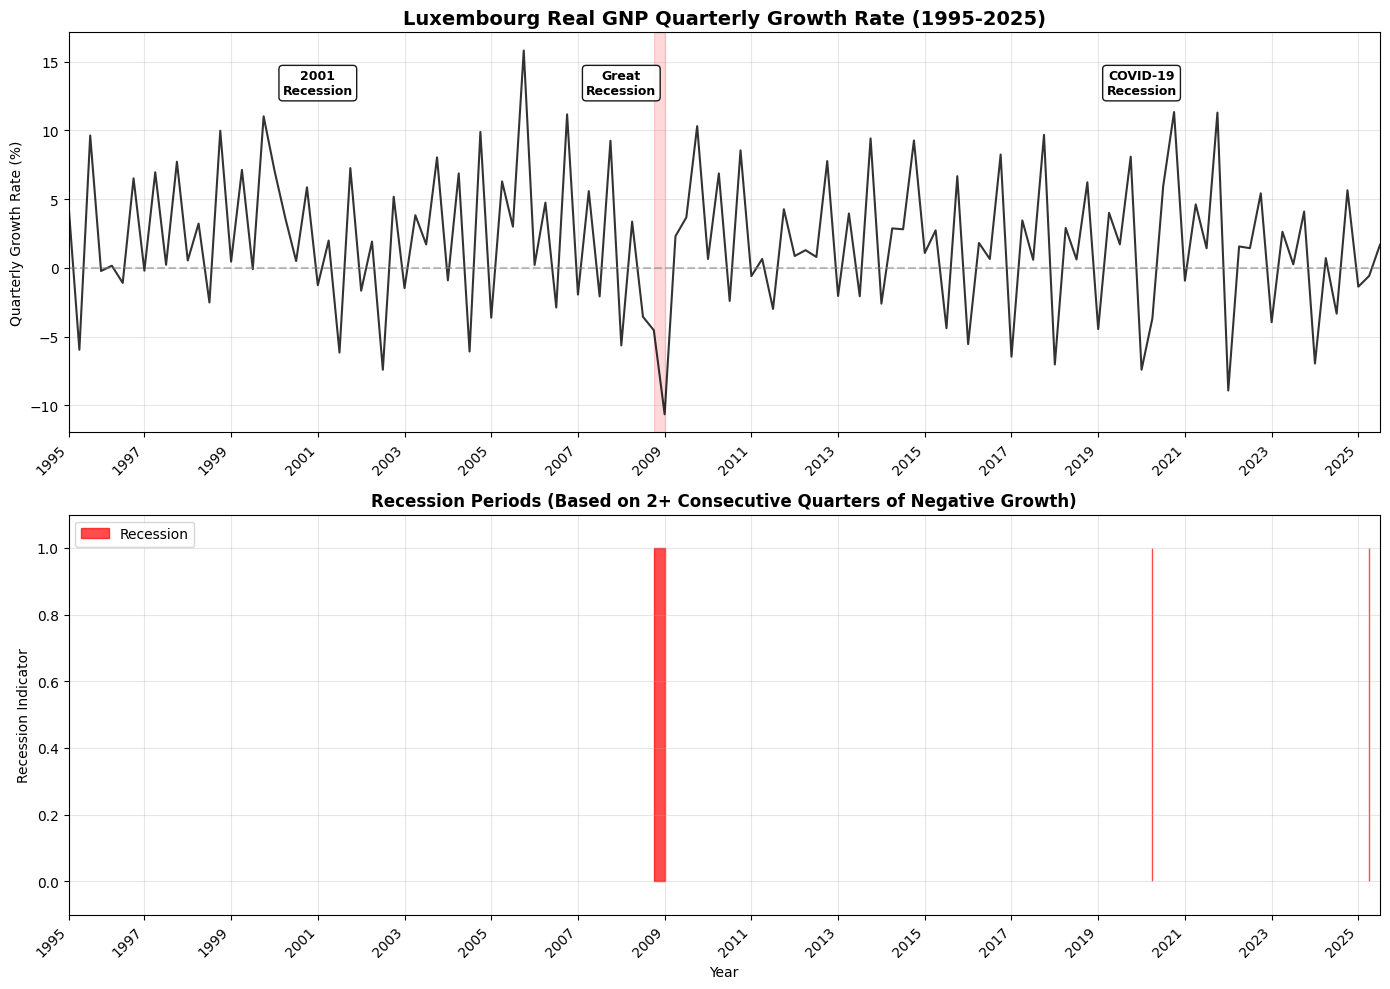


SUMMARY STATISTICS
Total quarters analyzed: 122 (1995 Q1 - 2025 Q3)
Average growth rate: 1.94%
Standard deviation: 5.11%
Maximum growth: 15.80%
Minimum growth: -10.65%

Identified 1 recession periods:
------------------------------------------------------------
Recession 1: 2008 Q%q to 2009 Q%q
  Duration: 2 quarters (0.5 years)
  Average growth during recession: -7.59%

Total quarters in recession: 2 (1.6%)
Total quarters in expansion: 120 (98.4%)



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Your data
data_str = """observation_date GNPCA
1995-01-01 6841.286
1995-04-01 7162.811
1995-07-01 6748.491
1995-10-01 7430.178
1996-01-01 7413.236
1996-04-01 7424.642
1996-07-01 7343.691
1996-10-01 7837.612
1997-01-01 7821.563
1997-04-01 8384.649
1997-07-01 8403.505
1997-10-01 9077.754
1998-01-01 9126.52
1998-04-01 9425.368
1998-07-01 9191.037
1998-10-01 10154.489
1999-01-01 10200.613
1999-04-01 10953.479
1999-07-01 10943.007
1999-10-01 12217.574
2000-01-01 13115.172
2000-04-01 13599.191
2000-07-01 13666.642
2000-10-01 14490.565
2001-01-01 14309.067
2001-04-01 14595.696
2001-07-01 13723.688
2001-10-01 14755.721
2002-01-01 14512.679
2002-04-01 14792.384
2002-07-01 13735.639
2002-10-01 14464.472
2003-01-01 14253.322
2003-04-01 14809.356
2003-07-01 15063.556
2003-10-01 16323.368
2004-01-01 16175.711
2004-04-01 17325.135
2004-07-01 16302.913
2004-10-01 17996.774
2005-01-01 17357.076
2005-04-01 18482.754
2005-07-01 19044.636
2005-10-01 22304.892
2006-01-01 22351.767
2006-04-01 23437.315
2006-07-01 22771.237
2006-10-01 25460.188
2007-01-01 24970.907
2007-04-01 26404.015
2007-07-01 25861.422
2007-10-01 28365.274
2008-01-01 26809.859
2008-04-01 27726.441
2008-07-01 26756.976
2008-10-01 25570.57
2009-01-01 22987.503
2009-04-01 23523.749
2009-07-01 24402.781
2009-10-01 27051.379
2010-01-01 27225.929
2010-04-01 29160.439
2010-07-01 28467.538
2010-10-01 31006.136
2011-01-01 30820.103
2011-04-01 31020.924
2011-07-01 30108.223
2011-10-01 31419.047
2012-01-01 31690.415
2012-04-01 32100.595
2012-07-01 32355.297
2012-10-01 34967.655
2013-01-01 34259.471
2013-04-01 35640.23
2013-07-01 34912.448
2013-10-01 38357.379
2014-01-01 37372.379
2014-04-01 38460.129
2014-07-01 39554.179
2014-10-01 43393.551
2015-01-01 43866.55
2015-04-01 45078.824
2015-07-01 43144.875
2015-10-01 46118.711
2016-01-01 43630.799
2016-04-01 44427.36
2016-07-01 44715.243
2016-10-01 48555.168
2017-01-01 45519.431
2017-04-01 47117.445
2017-07-01 47394.595
2017-10-01 52206.886
2018-01-01 48664.873
2018-04-01 50096.739
2018-07-01 50403.783
2018-10-01 53640.107
2019-01-01 51306.931
2019-04-01 53400.933
2019-07-01 54320.986
2019-10-01 58895.638
2020-01-01 54690.788
2020-04-01 52716.723
2020-07-01 55951.127
2020-10-01 62663.514
2021-01-01 62084.886
2021-04-01 65019.691
2021-07-01 65953.53
2021-10-01 73834.525
2022-01-01 67534.489
2022-04-01 68594.071
2022-07-01 69583.32
2022-10-01 73456.983
2023-01-01 70611.169
2023-04-01 72489.253
2023-07-01 72674.564
2023-10-01 75711.518
2024-01-01 70623.851
2024-04-01 71124.969
2024-07-01 68794.105
2024-10-01 72786.623
2025-01-01 71797.005
2025-04-01 71378.736
2025-07-01 72589.045
"""

# Parse data - using whitespace as separator
df = pd.read_csv(StringIO(data_str), sep='\s+')  # Changed from sep='\t' to sep='\s+'
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

# Calculate quarterly growth rates
growth = 100 * np.log(df['GNPCA'] / df['GNPCA'].shift(1)).dropna()

# Simple rule: recession if 2+ consecutive quarters of negative growth
growth_series = pd.Series(growth)  # Convert to Series for easier handling
recession_flag = np.zeros(len(growth_series))
for i in range(1, len(growth_series)):
    if growth_series.iloc[i] < 0 and growth_series.iloc[i-1] < 0:
        recession_flag[i] = 1

# Now the plotting code with years on x-axis
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Create year array for x-axis - using the actual dates from growth index
years = growth.index.year.tolist()
quarters = growth.index.quarter.tolist()

# Get unique years for tick marks
unique_years = sorted(set(years))
# Select every 3-5 years for better spacing
tick_interval = max(1, len(unique_years) // 15)  # Aim for about 15 ticks
tick_years = unique_years[::tick_interval]

# Get indices for these years (use first occurrence of each year)
tick_indices = []
for year in tick_years:
    try:
        idx = next(i for i, y in enumerate(years) if y == year)
        tick_indices.append(idx)
    except StopIteration:
        continue

# Plot 1: Growth rates
axes[0].plot(growth_series.values, 'k-', linewidth=1.5, alpha=0.8)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Quarterly Growth Rate (%)')
axes[0].set_title('Luxembourg Real GNP Quarterly Growth Rate (1995-2025)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# First, identify recession periods for shading
recession_periods = []
in_recession = False
recession_start = None

for i, flag in enumerate(recession_flag):
    if flag == 1 and not in_recession:
        in_recession = True
        recession_start = i
    elif flag == 0 and in_recession:
        in_recession = False
        # Only include recessions longer than 2 quarters (since we start with 2 consecutive negatives)
        if i - recession_start >= 2:
            recession_periods.append((recession_start, i-1))

if in_recession:
    recession_periods.append((recession_start, len(recession_flag)-1))

# Shade recession periods
for start_idx, end_idx in recession_periods:
    axes[0].axvspan(start_idx, end_idx, alpha=0.15, color='red')

# Plot 2: Recession indicator
axes[1].fill_between(range(len(growth_series)), 0, recession_flag, 
                     where=recession_flag>0, color='red', alpha=0.7, label='Recession')
axes[1].set_ylabel('Recession Indicator')
axes[1].set_title('Recession Periods (Based on 2+ Consecutive Quarters of Negative Growth)', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylim([-0.1, 1.1])
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper left')
axes[1].set_xlabel('Year')

# Set x-ticks for both plots
for ax in axes:
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_years, rotation=45, ha='right')
    ax.set_xlim([0, len(growth_series)-1])

# Add annotations for major recessions that occurred during our data period
# Only include recessions that actually happened in our timeframe
major_recessions_info = [
    (2001, 2001, "2001\nRecession"),
    (2007, 2009, "Great\nRecession"),
    (2020, 2020, "COVID-19\nRecession"),
]

# Find approximate indices for these recessions
for start_year_info, end_year_info, label in major_recessions_info:
    # Find closest indices
    start_idx_approx = next((i for i, y in enumerate(years) if y == start_year_info), None)
    end_idx_approx = next((i for i, y in enumerate(years) if y == end_year_info), None)
    
    if start_idx_approx is not None and end_idx_approx is not None:
        mid_idx = (start_idx_approx + end_idx_approx) // 2
        # Position label near top of plot
        label_y = np.max(growth_series.values) * 0.85 if np.max(growth_series.values) > 5 else 5
        axes[0].text(mid_idx, label_y, label, 
                    ha='center', va='center', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"Total quarters analyzed: {len(growth_series)} (1995 Q1 - 2025 Q3)")
print(f"Average growth rate: {np.mean(growth_series.values):.2f}%")
print(f"Standard deviation: {np.std(growth_series.values):.2f}%")
print(f"Maximum growth: {np.max(growth_series.values):.2f}%")
print(f"Minimum growth: {np.min(growth_series.values):.2f}%")

# Count recession periods
if recession_periods:
    print(f"\nIdentified {len(recession_periods)} recession periods:")
    print("-" * 60)
    
    total_recession_quarters = 0
    for idx, (start_idx, end_idx) in enumerate(recession_periods):
        # Get actual dates from the index
        start_date = growth.index[start_idx]
        end_date = growth.index[end_idx]
        
        duration_quarters = end_idx - start_idx + 1
        duration_years = duration_quarters / 4
        total_recession_quarters += duration_quarters
        
        recession_growth = growth_series.values[start_idx:end_idx+1]
        avg_growth = np.mean(recession_growth)
        
        print(f"Recession {idx+1}: {start_date.strftime('%Y Q%q').replace('Q0', 'Q')} to {end_date.strftime('%Y Q%q').replace('Q0', 'Q')}")
        print(f"  Duration: {duration_quarters} quarters ({duration_years:.1f} years)")
        print(f"  Average growth during recession: {avg_growth:.2f}%")
        print()
    
    recession_percentage = total_recession_quarters / len(growth_series) * 100
    print(f"Total quarters in recession: {total_recession_quarters} ({recession_percentage:.1f}%)")
    print(f"Total quarters in expansion: {len(growth_series) - total_recession_quarters} ({100 - recession_percentage:.1f}%)")
else:
    print("\nNo recession periods identified.")

print("\n" + "=" * 70)